In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(249266, 828)
(249266, 8)
validation
(44338, 828)
(44338, 8)
test
(22164, 828)
(22164, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/25 [>.............................] - ETA: 40s - loss: 2.1321 - STD: 0.0570 - MAE: 0.2189

 4/25 [===>..........................] - ETA: 0s - loss: 1.6434 - STD: 0.1135 - MAE: 0.1832 

 5/25 [=====>........................] - ETA: 0s - loss: 1.5931 - STD: 0.1363 - MAE: 0.1736

 6/25 [======>.......................] - ETA: 0s - loss: 1.5622 - STD: 0.1538 - MAE: 0.1663

 7/25 [=======>......................] - ETA: 0s - loss: 1.5426 - STD: 0.1667 - MAE: 0.1610

 8/25 [========>.....................] - ETA: 0s - loss: 1.5257 - STD: 0.1759 - MAE: 0.1571

 9/25 [=========>....................] - ETA: 0s - loss: 1.5109 - STD: 0.1820 - MAE: 0.1544

10/25 [===========>..................] - ETA: 0s - loss: 1.4974 - STD: 0.1857 - MAE: 0.1527

11/25 [============>.................] - ETA: 0s - loss: 1.4845 - STD: 0.1876 - MAE: 0.1516

12/25 [=============>................] - ETA: 0s - loss: 1.4758 - STD: 0.1883 - MAE: 0.1513

13/25 [==============>...............] - ETA: 0s - loss: 1.4678 - STD: 0.1883 - MAE: 0.1511

14/25 [===============>..............] - ETA: 0s - loss: 1.4607 - STD: 0.1878 - MAE: 0.1512

15/25 [=================>............] - ETA: 0s - loss: 1.4533 - STD: 0.1871 - MAE: 0.1513

16/25 [==================>...........] - ETA: 0s - loss: 1.4478 - STD: 0.1863 - MAE: 0.1515

17/25 [===================>..........] - ETA: 0s - loss: 1.4423 - STD: 0.1856 - MAE: 0.1517

18/25 [====================>.........] - ETA: 0s - loss: 1.4374 - STD: 0.1849 - MAE: 0.1518

19/25 [=====================>........] - ETA: 0s - loss: 1.4337 - STD: 0.1844 - MAE: 0.1520

20/25 [=======================>......] - ETA: 0s - loss: 1.4293 - STD: 0.1841 - MAE: 0.1520

21/25 [========================>.....] - ETA: 0s - loss: 1.4259 - STD: 0.1839 - MAE: 0.1520

22/25 [=========================>....] - ETA: 0s - loss: 1.4238 - STD: 0.1839 - MAE: 0.1520

25/25 [==============================] - ETA: 0s - loss: 1.4163 - STD: 0.1844 - MAE: 0.1517

25/25 [==============================] - 5s 135ms/step - loss: 1.4163 - STD: 0.1844 - MAE: 0.1517 - val_loss: 1.3850 - val_STD: 0.1898 - val_MAE: 0.1518


Epoch 2/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.3254 - STD: 0.1898 - MAE: 0.1470

 2/25 [=>............................] - ETA: 1s - loss: 1.3317 - STD: 0.1898 - MAE: 0.1472

 3/25 [==>...........................] - ETA: 1s - loss: 1.3368 - STD: 0.1898 - MAE: 0.1476

 4/25 [===>..........................] - ETA: 1s - loss: 1.3471 - STD: 0.1896 - MAE: 0.1483

 5/25 [=====>........................] - ETA: 1s - loss: 1.3457 - STD: 0.1893 - MAE: 0.1483

 6/25 [======>.......................] - ETA: 1s - loss: 1.3470 - STD: 0.1890 - MAE: 0.1486

 7/25 [=======>......................] - ETA: 1s - loss: 1.3468 - STD: 0.1886 - MAE: 0.1487

 8/25 [========>.....................] - ETA: 1s - loss: 1.3474 - STD: 0.1883 - MAE: 0.1489

 9/25 [=========>....................] - ETA: 1s - loss: 1.3491 - STD: 0.1881 - MAE: 0.1490

10/25 [===========>..................] - ETA: 1s - loss: 1.3501 - STD: 0.1879 - MAE: 0.1492

11/25 [============>.................] - ETA: 0s - loss: 1.3490 - STD: 0.1877 - MAE: 0.1492

12/25 [=============>................] - ETA: 0s - loss: 1.3495 - STD: 0.1876 - MAE: 0.1493

13/25 [==============>...............] - ETA: 0s - loss: 1.3491 - STD: 0.1876 - MAE: 0.1493

14/25 [===============>..............] - ETA: 0s - loss: 1.3485 - STD: 0.1875 - MAE: 0.1493

15/25 [=================>............] - ETA: 0s - loss: 1.3485 - STD: 0.1874 - MAE: 0.1493

16/25 [==================>...........] - ETA: 0s - loss: 1.3491 - STD: 0.1873 - MAE: 0.1494

17/25 [===================>..........] - ETA: 0s - loss: 1.3484 - STD: 0.1872 - MAE: 0.1494

18/25 [====================>.........] - ETA: 0s - loss: 1.3475 - STD: 0.1871 - MAE: 0.1494

19/25 [=====================>........] - ETA: 0s - loss: 1.3475 - STD: 0.1869 - MAE: 0.1494

20/25 [=======================>......] - ETA: 0s - loss: 1.3477 - STD: 0.1868 - MAE: 0.1495

21/25 [========================>.....] - ETA: 0s - loss: 1.3471 - STD: 0.1867 - MAE: 0.1495

22/25 [=========================>....] - ETA: 0s - loss: 1.3475 - STD: 0.1865 - MAE: 0.1496

23/25 [==========================>...] - ETA: 0s - loss: 1.3475 - STD: 0.1864 - MAE: 0.1497

24/25 [===========================>..] - ETA: 0s - loss: 1.3478 - STD: 0.1862 - MAE: 0.1497

25/25 [==============================] - ETA: 0s - loss: 1.3472 - STD: 0.1861 - MAE: 0.1498

25/25 [==============================] - 2s 74ms/step - loss: 1.3472 - STD: 0.1861 - MAE: 0.1498 - val_loss: 1.3773 - val_STD: 0.1838 - val_MAE: 0.1538


Epoch 3/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.3422 - STD: 0.1838 - MAE: 0.1502

 2/25 [=>............................] - ETA: 1s - loss: 1.3479 - STD: 0.1842 - MAE: 0.1505

 3/25 [==>...........................] - ETA: 1s - loss: 1.3435 - STD: 0.1845 - MAE: 0.1502

 4/25 [===>..........................] - ETA: 1s - loss: 1.3450 - STD: 0.1848 - MAE: 0.1502

 5/25 [=====>........................] - ETA: 1s - loss: 1.3439 - STD: 0.1851 - MAE: 0.1501

 6/25 [======>.......................] - ETA: 1s - loss: 1.3432 - STD: 0.1853 - MAE: 0.1499

 7/25 [=======>......................] - ETA: 1s - loss: 1.3438 - STD: 0.1855 - MAE: 0.1499

 8/25 [========>.....................] - ETA: 1s - loss: 1.3444 - STD: 0.1856 - MAE: 0.1498

 9/25 [=========>....................] - ETA: 1s - loss: 1.3434 - STD: 0.1857 - MAE: 0.1497

10/25 [===========>..................] - ETA: 1s - loss: 1.3422 - STD: 0.1858 - MAE: 0.1497

11/25 [============>.................] - ETA: 0s - loss: 1.3430 - STD: 0.1859 - MAE: 0.1497

12/25 [=============>................] - ETA: 0s - loss: 1.3443 - STD: 0.1859 - MAE: 0.1498

13/25 [==============>...............] - ETA: 0s - loss: 1.3449 - STD: 0.1858 - MAE: 0.1498

14/25 [===============>..............] - ETA: 0s - loss: 1.3451 - STD: 0.1857 - MAE: 0.1499

15/25 [=================>............] - ETA: 0s - loss: 1.3466 - STD: 0.1856 - MAE: 0.1500

16/25 [==================>...........] - ETA: 0s - loss: 1.3461 - STD: 0.1854 - MAE: 0.1501

17/25 [===================>..........] - ETA: 0s - loss: 1.3459 - STD: 0.1852 - MAE: 0.1501

18/25 [====================>.........] - ETA: 0s - loss: 1.3449 - STD: 0.1851 - MAE: 0.1501

19/25 [=====================>........] - ETA: 0s - loss: 1.3447 - STD: 0.1850 - MAE: 0.1501

20/25 [=======================>......] - ETA: 0s - loss: 1.3449 - STD: 0.1850 - MAE: 0.1501

21/25 [========================>.....] - ETA: 0s - loss: 1.3448 - STD: 0.1851 - MAE: 0.1501

22/25 [=========================>....] - ETA: 0s - loss: 1.3443 - STD: 0.1852 - MAE: 0.1500

23/25 [==========================>...] - ETA: 0s - loss: 1.3451 - STD: 0.1854 - MAE: 0.1500

24/25 [===========================>..] - ETA: 0s - loss: 1.3444 - STD: 0.1855 - MAE: 0.1499

25/25 [==============================] - ETA: 0s - loss: 1.3447 - STD: 0.1856 - MAE: 0.1499

25/25 [==============================] - 2s 74ms/step - loss: 1.3447 - STD: 0.1856 - MAE: 0.1499 - val_loss: 1.3745 - val_STD: 0.1876 - val_MAE: 0.1524


Epoch 4/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.3516 - STD: 0.1876 - MAE: 0.1497

 2/25 [=>............................] - ETA: 1s - loss: 1.3410 - STD: 0.1869 - MAE: 0.1493

 3/25 [==>...........................] - ETA: 1s - loss: 1.3405 - STD: 0.1863 - MAE: 0.1494

 4/25 [===>..........................] - ETA: 1s - loss: 1.3400 - STD: 0.1858 - MAE: 0.1496

 5/25 [=====>........................] - ETA: 1s - loss: 1.3391 - STD: 0.1854 - MAE: 0.1497

 6/25 [======>.......................] - ETA: 1s - loss: 1.3368 - STD: 0.1852 - MAE: 0.1497

 7/25 [=======>......................] - ETA: 1s - loss: 1.3391 - STD: 0.1851 - MAE: 0.1498

 8/25 [========>.....................] - ETA: 1s - loss: 1.3407 - STD: 0.1851 - MAE: 0.1499

 9/25 [=========>....................] - ETA: 1s - loss: 1.3394 - STD: 0.1851 - MAE: 0.1498

10/25 [===========>..................] - ETA: 1s - loss: 1.3408 - STD: 0.1852 - MAE: 0.1498

11/25 [============>.................] - ETA: 0s - loss: 1.3423 - STD: 0.1853 - MAE: 0.1498

12/25 [=============>................] - ETA: 0s - loss: 1.3430 - STD: 0.1854 - MAE: 0.1498

13/25 [==============>...............] - ETA: 0s - loss: 1.3427 - STD: 0.1854 - MAE: 0.1498

14/25 [===============>..............] - ETA: 0s - loss: 1.3423 - STD: 0.1854 - MAE: 0.1498

15/25 [=================>............] - ETA: 0s - loss: 1.3423 - STD: 0.1853 - MAE: 0.1498

16/25 [==================>...........] - ETA: 0s - loss: 1.3422 - STD: 0.1852 - MAE: 0.1499

17/25 [===================>..........] - ETA: 0s - loss: 1.3406 - STD: 0.1851 - MAE: 0.1498

18/25 [====================>.........] - ETA: 0s - loss: 1.3403 - STD: 0.1851 - MAE: 0.1498

19/25 [=====================>........] - ETA: 0s - loss: 1.3410 - STD: 0.1851 - MAE: 0.1498

20/25 [=======================>......] - ETA: 0s - loss: 1.3414 - STD: 0.1852 - MAE: 0.1498

21/25 [========================>.....] - ETA: 0s - loss: 1.3415 - STD: 0.1852 - MAE: 0.1498

22/25 [=========================>....] - ETA: 0s - loss: 1.3415 - STD: 0.1851 - MAE: 0.1499

23/25 [==========================>...] - ETA: 0s - loss: 1.3404 - STD: 0.1851 - MAE: 0.1498

24/25 [===========================>..] - ETA: 0s - loss: 1.3393 - STD: 0.1851 - MAE: 0.1497

25/25 [==============================] - ETA: 0s - loss: 1.3398 - STD: 0.1851 - MAE: 0.1498

25/25 [==============================] - 2s 73ms/step - loss: 1.3398 - STD: 0.1851 - MAE: 0.1498 - val_loss: 1.3577 - val_STD: 0.1859 - val_MAE: 0.1520


Epoch 5/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.3227 - STD: 0.1864 - MAE: 0.1482

 2/25 [=>............................] - ETA: 1s - loss: 1.3235 - STD: 0.1866 - MAE: 0.1481

 3/25 [==>...........................] - ETA: 1s - loss: 1.3276 - STD: 0.1866 - MAE: 0.1483

 4/25 [===>..........................] - ETA: 1s - loss: 1.3262 - STD: 0.1865 - MAE: 0.1483

 5/25 [=====>........................] - ETA: 1s - loss: 1.3255 - STD: 0.1862 - MAE: 0.1484

 6/25 [======>.......................] - ETA: 1s - loss: 1.3253 - STD: 0.1860 - MAE: 0.1485

 7/25 [=======>......................] - ETA: 1s - loss: 1.3249 - STD: 0.1858 - MAE: 0.1486

 8/25 [========>.....................] - ETA: 1s - loss: 1.3235 - STD: 0.1856 - MAE: 0.1485

 9/25 [=========>....................] - ETA: 1s - loss: 1.3243 - STD: 0.1856 - MAE: 0.1486

10/25 [===========>..................] - ETA: 0s - loss: 1.3219 - STD: 0.1857 - MAE: 0.1484

11/25 [============>.................] - ETA: 0s - loss: 1.3221 - STD: 0.1858 - MAE: 0.1484

12/25 [=============>................] - ETA: 0s - loss: 1.3229 - STD: 0.1858 - MAE: 0.1484

13/25 [==============>...............] - ETA: 0s - loss: 1.3212 - STD: 0.1857 - MAE: 0.1484

14/25 [===============>..............] - ETA: 0s - loss: 1.3196 - STD: 0.1856 - MAE: 0.1483

15/25 [=================>............] - ETA: 0s - loss: 1.3185 - STD: 0.1856 - MAE: 0.1482

16/25 [==================>...........] - ETA: 0s - loss: 1.3176 - STD: 0.1856 - MAE: 0.1481

17/25 [===================>..........] - ETA: 0s - loss: 1.3153 - STD: 0.1857 - MAE: 0.1480

18/25 [====================>.........] - ETA: 0s - loss: 1.3144 - STD: 0.1859 - MAE: 0.1478

19/25 [=====================>........] - ETA: 0s - loss: 1.3132 - STD: 0.1861 - MAE: 0.1477

20/25 [=======================>......] - ETA: 0s - loss: 1.3117 - STD: 0.1862 - MAE: 0.1475

21/25 [========================>.....] - ETA: 0s - loss: 1.3103 - STD: 0.1863 - MAE: 0.1474

22/25 [=========================>....] - ETA: 0s - loss: 1.3095 - STD: 0.1863 - MAE: 0.1473

23/25 [==========================>...] - ETA: 0s - loss: 1.3080 - STD: 0.1864 - MAE: 0.1472

24/25 [===========================>..] - ETA: 0s - loss: 1.3066 - STD: 0.1865 - MAE: 0.1471

25/25 [==============================] - ETA: 0s - loss: 1.3053 - STD: 0.1867 - MAE: 0.1469

25/25 [==============================] - 2s 73ms/step - loss: 1.3053 - STD: 0.1867 - MAE: 0.1469 - val_loss: 1.2900 - val_STD: 0.1817 - val_MAE: 0.1489


Epoch 6/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.2631 - STD: 0.1905 - MAE: 0.1429

 2/25 [=>............................] - ETA: 1s - loss: 1.2609 - STD: 0.1901 - MAE: 0.1429

 3/25 [==>...........................] - ETA: 1s - loss: 1.2655 - STD: 0.1909 - MAE: 0.1429

 4/25 [===>..........................] - ETA: 1s - loss: 1.2633 - STD: 0.1909 - MAE: 0.1428

 5/25 [=====>........................] - ETA: 1s - loss: 1.2610 - STD: 0.1908 - MAE: 0.1427

 6/25 [======>.......................] - ETA: 1s - loss: 1.2589 - STD: 0.1914 - MAE: 0.1424

 7/25 [=======>......................] - ETA: 1s - loss: 1.2571 - STD: 0.1920 - MAE: 0.1420

 8/25 [========>.....................] - ETA: 1s - loss: 1.2573 - STD: 0.1924 - MAE: 0.1419

 9/25 [=========>....................] - ETA: 1s - loss: 1.2579 - STD: 0.1922 - MAE: 0.1419

10/25 [===========>..................] - ETA: 1s - loss: 1.2567 - STD: 0.1920 - MAE: 0.1419

11/25 [============>.................] - ETA: 0s - loss: 1.2565 - STD: 0.1933 - MAE: 0.1414

12/25 [=============>................] - ETA: 0s - loss: 1.2549 - STD: 0.1939 - MAE: 0.1411

13/25 [==============>...............] - ETA: 0s - loss: 1.2534 - STD: 0.1935 - MAE: 0.1411

14/25 [===============>..............] - ETA: 0s - loss: 1.2529 - STD: 0.1936 - MAE: 0.1410

15/25 [=================>............] - ETA: 0s - loss: 1.2517 - STD: 0.1945 - MAE: 0.1406

16/25 [==================>...........] - ETA: 0s - loss: 1.2497 - STD: 0.1951 - MAE: 0.1403

17/25 [===================>..........] - ETA: 0s - loss: 1.2488 - STD: 0.1953 - MAE: 0.1402

18/25 [====================>.........] - ETA: 0s - loss: 1.2480 - STD: 0.1952 - MAE: 0.1402

19/25 [=====================>........] - ETA: 0s - loss: 1.2464 - STD: 0.1954 - MAE: 0.1400

20/25 [=======================>......] - ETA: 0s - loss: 1.2457 - STD: 0.1960 - MAE: 0.1397

21/25 [========================>.....] - ETA: 0s - loss: 1.2442 - STD: 0.1962 - MAE: 0.1395

22/25 [=========================>....] - ETA: 0s - loss: 1.2433 - STD: 0.1961 - MAE: 0.1395

23/25 [==========================>...] - ETA: 0s - loss: 1.2419 - STD: 0.1965 - MAE: 0.1393

24/25 [===========================>..] - ETA: 0s - loss: 1.2411 - STD: 0.1971 - MAE: 0.1390

25/25 [==============================] - ETA: 0s - loss: 1.2406 - STD: 0.1969 - MAE: 0.1390

25/25 [==============================] - 2s 74ms/step - loss: 1.2406 - STD: 0.1969 - MAE: 0.1390 - val_loss: 1.2355 - val_STD: 0.1831 - val_MAE: 0.1452


Epoch 7/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.2286 - STD: 0.1959 - MAE: 0.1390

 2/25 [=>............................] - ETA: 1s - loss: 1.2049 - STD: 0.2020 - MAE: 0.1353

 3/25 [==>...........................] - ETA: 1s - loss: 1.2092 - STD: 0.2065 - MAE: 0.1337

 4/25 [===>..........................] - ETA: 1s - loss: 1.2107 - STD: 0.2029 - MAE: 0.1352

 5/25 [=====>........................] - ETA: 1s - loss: 1.2100 - STD: 0.2010 - MAE: 0.1359

 6/25 [======>.......................] - ETA: 1s - loss: 1.2113 - STD: 0.2031 - MAE: 0.1352

 7/25 [=======>......................] - ETA: 1s - loss: 1.2102 - STD: 0.2033 - MAE: 0.1351

 8/25 [========>.....................] - ETA: 1s - loss: 1.2107 - STD: 0.2016 - MAE: 0.1358

 9/25 [=========>....................] - ETA: 1s - loss: 1.2073 - STD: 0.2009 - MAE: 0.1359

10/25 [===========>..................] - ETA: 0s - loss: 1.2069 - STD: 0.2024 - MAE: 0.1353

11/25 [============>.................] - ETA: 0s - loss: 1.2061 - STD: 0.2026 - MAE: 0.1352

12/25 [=============>................] - ETA: 0s - loss: 1.2058 - STD: 0.2015 - MAE: 0.1356

13/25 [==============>...............] - ETA: 0s - loss: 1.2014 - STD: 0.2018 - MAE: 0.1352

14/25 [===============>..............] - ETA: 0s - loss: 1.1997 - STD: 0.2033 - MAE: 0.1345

15/25 [=================>............] - ETA: 0s - loss: 1.1989 - STD: 0.2032 - MAE: 0.1345

16/25 [==================>...........] - ETA: 0s - loss: 1.1982 - STD: 0.2024 - MAE: 0.1349

17/25 [===================>..........] - ETA: 0s - loss: 1.1964 - STD: 0.2024 - MAE: 0.1348

18/25 [====================>.........] - ETA: 0s - loss: 1.1968 - STD: 0.2035 - MAE: 0.1344

19/25 [=====================>........] - ETA: 0s - loss: 1.1962 - STD: 0.2035 - MAE: 0.1344

20/25 [=======================>......] - ETA: 0s - loss: 1.1947 - STD: 0.2027 - MAE: 0.1346

21/25 [========================>.....] - ETA: 0s - loss: 1.1930 - STD: 0.2026 - MAE: 0.1346

22/25 [=========================>....] - ETA: 0s - loss: 1.1918 - STD: 0.2034 - MAE: 0.1342

23/25 [==========================>...] - ETA: 0s - loss: 1.1901 - STD: 0.2038 - MAE: 0.1340

24/25 [===========================>..] - ETA: 0s - loss: 1.1887 - STD: 0.2035 - MAE: 0.1341

25/25 [==============================] - ETA: 0s - loss: 1.1874 - STD: 0.2033 - MAE: 0.1341

25/25 [==============================] - 2s 72ms/step - loss: 1.1874 - STD: 0.2033 - MAE: 0.1341 - val_loss: 1.1601 - val_STD: 0.1970 - val_MAE: 0.1374


Epoch 8/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.1496 - STD: 0.2096 - MAE: 0.1303

 2/25 [=>............................] - ETA: 1s - loss: 1.1452 - STD: 0.2124 - MAE: 0.1289

 3/25 [==>...........................] - ETA: 1s - loss: 1.1359 - STD: 0.2106 - MAE: 0.1292

 4/25 [===>..........................] - ETA: 1s - loss: 1.1385 - STD: 0.2086 - MAE: 0.1301

 5/25 [=====>........................] - ETA: 1s - loss: 1.1348 - STD: 0.2086 - MAE: 0.1300

 6/25 [======>.......................] - ETA: 1s - loss: 1.1319 - STD: 0.2094 - MAE: 0.1295

 7/25 [=======>......................] - ETA: 1s - loss: 1.1285 - STD: 0.2100 - MAE: 0.1291

 8/25 [========>.....................] - ETA: 1s - loss: 1.1292 - STD: 0.2097 - MAE: 0.1293

 9/25 [=========>....................] - ETA: 1s - loss: 1.1281 - STD: 0.2091 - MAE: 0.1296

10/25 [===========>..................] - ETA: 1s - loss: 1.1274 - STD: 0.2090 - MAE: 0.1296

11/25 [============>.................] - ETA: 0s - loss: 1.1272 - STD: 0.2093 - MAE: 0.1295

12/25 [=============>................] - ETA: 0s - loss: 1.1254 - STD: 0.2093 - MAE: 0.1295

13/25 [==============>...............] - ETA: 0s - loss: 1.1253 - STD: 0.2093 - MAE: 0.1295

14/25 [===============>..............] - ETA: 0s - loss: 1.1240 - STD: 0.2096 - MAE: 0.1294

15/25 [=================>............] - ETA: 0s - loss: 1.1226 - STD: 0.2098 - MAE: 0.1292

16/25 [==================>...........] - ETA: 0s - loss: 1.1203 - STD: 0.2097 - MAE: 0.1292

17/25 [===================>..........] - ETA: 0s - loss: 1.1195 - STD: 0.2098 - MAE: 0.1291

18/25 [====================>.........] - ETA: 0s - loss: 1.1199 - STD: 0.2102 - MAE: 0.1290

19/25 [=====================>........] - ETA: 0s - loss: 1.1196 - STD: 0.2096 - MAE: 0.1293

20/25 [=======================>......] - ETA: 0s - loss: 1.1189 - STD: 0.2096 - MAE: 0.1293

21/25 [========================>.....] - ETA: 0s - loss: 1.1186 - STD: 0.2100 - MAE: 0.1291

22/25 [=========================>....] - ETA: 0s - loss: 1.1185 - STD: 0.2098 - MAE: 0.1292

23/25 [==========================>...] - ETA: 0s - loss: 1.1177 - STD: 0.2096 - MAE: 0.1293

24/25 [===========================>..] - ETA: 0s - loss: 1.1171 - STD: 0.2097 - MAE: 0.1292

25/25 [==============================] - ETA: 0s - loss: 1.1170 - STD: 0.2098 - MAE: 0.1292

25/25 [==============================] - 2s 74ms/step - loss: 1.1170 - STD: 0.2098 - MAE: 0.1292 - val_loss: 1.1415 - val_STD: 0.1979 - val_MAE: 0.1387


Epoch 9/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.1135 - STD: 0.2069 - MAE: 0.1310

 2/25 [=>............................] - ETA: 1s - loss: 1.1007 - STD: 0.2069 - MAE: 0.1302

 3/25 [==>...........................] - ETA: 1s - loss: 1.0976 - STD: 0.2100 - MAE: 0.1287

 4/25 [===>..........................] - ETA: 1s - loss: 1.0948 - STD: 0.2108 - MAE: 0.1283

 5/25 [=====>........................] - ETA: 1s - loss: 1.0954 - STD: 0.2104 - MAE: 0.1285

 6/25 [======>.......................] - ETA: 1s - loss: 1.0942 - STD: 0.2103 - MAE: 0.1285

 7/25 [=======>......................] - ETA: 1s - loss: 1.0927 - STD: 0.2110 - MAE: 0.1281

 8/25 [========>.....................] - ETA: 1s - loss: 1.0908 - STD: 0.2111 - MAE: 0.1280

 9/25 [=========>....................] - ETA: 1s - loss: 1.0898 - STD: 0.2113 - MAE: 0.1278

10/25 [===========>..................] - ETA: 0s - loss: 1.0898 - STD: 0.2116 - MAE: 0.1278

11/25 [============>.................] - ETA: 0s - loss: 1.0897 - STD: 0.2115 - MAE: 0.1278

12/25 [=============>................] - ETA: 0s - loss: 1.0885 - STD: 0.2114 - MAE: 0.1278

13/25 [==============>...............] - ETA: 0s - loss: 1.0866 - STD: 0.2118 - MAE: 0.1275

14/25 [===============>..............] - ETA: 0s - loss: 1.0852 - STD: 0.2120 - MAE: 0.1273

15/25 [=================>............] - ETA: 0s - loss: 1.0849 - STD: 0.2117 - MAE: 0.1274

16/25 [==================>...........] - ETA: 0s - loss: 1.0847 - STD: 0.2118 - MAE: 0.1274

17/25 [===================>..........] - ETA: 0s - loss: 1.0840 - STD: 0.2122 - MAE: 0.1272

18/25 [====================>.........] - ETA: 0s - loss: 1.0839 - STD: 0.2119 - MAE: 0.1274

19/25 [=====================>........] - ETA: 0s - loss: 1.0833 - STD: 0.2120 - MAE: 0.1273

20/25 [=======================>......] - ETA: 0s - loss: 1.0831 - STD: 0.2124 - MAE: 0.1272

21/25 [========================>.....] - ETA: 0s - loss: 1.0824 - STD: 0.2121 - MAE: 0.1272

22/25 [=========================>....] - ETA: 0s - loss: 1.0822 - STD: 0.2125 - MAE: 0.1271

23/25 [==========================>...] - ETA: 0s - loss: 1.0817 - STD: 0.2125 - MAE: 0.1271

24/25 [===========================>..] - ETA: 0s - loss: 1.0812 - STD: 0.2123 - MAE: 0.1271

25/25 [==============================] - ETA: 0s - loss: 1.0807 - STD: 0.2125 - MAE: 0.1271

25/25 [==============================] - 2s 72ms/step - loss: 1.0807 - STD: 0.2125 - MAE: 0.1271 - val_loss: 1.1322 - val_STD: 0.2089 - val_MAE: 0.1336


Epoch 10/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.0701 - STD: 0.2151 - MAE: 0.1257

 2/25 [=>............................] - ETA: 1s - loss: 1.0715 - STD: 0.2133 - MAE: 0.1266

 3/25 [==>...........................] - ETA: 1s - loss: 1.0728 - STD: 0.2115 - MAE: 0.1275

 4/25 [===>..........................] - ETA: 1s - loss: 1.0685 - STD: 0.2133 - MAE: 0.1265

 5/25 [=====>........................] - ETA: 1s - loss: 1.0676 - STD: 0.2133 - MAE: 0.1264

 6/25 [======>.......................] - ETA: 1s - loss: 1.0664 - STD: 0.2132 - MAE: 0.1264

 7/25 [=======>......................] - ETA: 1s - loss: 1.0651 - STD: 0.2138 - MAE: 0.1261

 8/25 [========>.....................] - ETA: 1s - loss: 1.0663 - STD: 0.2137 - MAE: 0.1262

 9/25 [=========>....................] - ETA: 1s - loss: 1.0665 - STD: 0.2127 - MAE: 0.1266

10/25 [===========>..................] - ETA: 0s - loss: 1.0646 - STD: 0.2139 - MAE: 0.1260

11/25 [============>.................] - ETA: 0s - loss: 1.0668 - STD: 0.2139 - MAE: 0.1262

12/25 [=============>................] - ETA: 0s - loss: 1.0666 - STD: 0.2127 - MAE: 0.1266

13/25 [==============>...............] - ETA: 0s - loss: 1.0645 - STD: 0.2137 - MAE: 0.1261

14/25 [===============>..............] - ETA: 0s - loss: 1.0638 - STD: 0.2147 - MAE: 0.1257

15/25 [=================>............] - ETA: 0s - loss: 1.0638 - STD: 0.2137 - MAE: 0.1261

16/25 [==================>...........] - ETA: 0s - loss: 1.0637 - STD: 0.2130 - MAE: 0.1264

17/25 [===================>..........] - ETA: 0s - loss: 1.0629 - STD: 0.2139 - MAE: 0.1260

18/25 [====================>.........] - ETA: 0s - loss: 1.0638 - STD: 0.2146 - MAE: 0.1258

19/25 [=====================>........] - ETA: 0s - loss: 1.0640 - STD: 0.2136 - MAE: 0.1262

20/25 [=======================>......] - ETA: 0s - loss: 1.0627 - STD: 0.2130 - MAE: 0.1264

21/25 [========================>.....] - ETA: 0s - loss: 1.0623 - STD: 0.2137 - MAE: 0.1261

22/25 [=========================>....] - ETA: 0s - loss: 1.0617 - STD: 0.2144 - MAE: 0.1258

23/25 [==========================>...] - ETA: 0s - loss: 1.0613 - STD: 0.2140 - MAE: 0.1260

24/25 [===========================>..] - ETA: 0s - loss: 1.0613 - STD: 0.2134 - MAE: 0.1263

25/25 [==============================] - ETA: 0s - loss: 1.0604 - STD: 0.2136 - MAE: 0.1262

25/25 [==============================] - 2s 72ms/step - loss: 1.0604 - STD: 0.2136 - MAE: 0.1262 - val_loss: 1.1561 - val_STD: 0.2223 - val_MAE: 0.1295


Epoch 11/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.0826 - STD: 0.2278 - MAE: 0.1216

 2/25 [=>............................] - ETA: 1s - loss: 1.0616 - STD: 0.2214 - MAE: 0.1234

 3/25 [==>...........................] - ETA: 1s - loss: 1.0567 - STD: 0.2157 - MAE: 0.1256

 4/25 [===>..........................] - ETA: 1s - loss: 1.0537 - STD: 0.2139 - MAE: 0.1262

 5/25 [=====>........................] - ETA: 1s - loss: 1.0516 - STD: 0.2152 - MAE: 0.1256

 6/25 [======>.......................] - ETA: 1s - loss: 1.0542 - STD: 0.2170 - MAE: 0.1250

 7/25 [=======>......................] - ETA: 1s - loss: 1.0523 - STD: 0.2163 - MAE: 0.1252

 8/25 [========>.....................] - ETA: 1s - loss: 1.0503 - STD: 0.2147 - MAE: 0.1258

 9/25 [=========>....................] - ETA: 1s - loss: 1.0488 - STD: 0.2141 - MAE: 0.1259

10/25 [===========>..................] - ETA: 0s - loss: 1.0466 - STD: 0.2150 - MAE: 0.1254

11/25 [============>.................] - ETA: 0s - loss: 1.0443 - STD: 0.2156 - MAE: 0.1250

12/25 [=============>................] - ETA: 0s - loss: 1.0435 - STD: 0.2154 - MAE: 0.1251

13/25 [==============>...............] - ETA: 0s - loss: 1.0417 - STD: 0.2148 - MAE: 0.1252

14/25 [===============>..............] - ETA: 0s - loss: 1.0399 - STD: 0.2151 - MAE: 0.1250

15/25 [=================>............] - ETA: 0s - loss: 1.0389 - STD: 0.2158 - MAE: 0.1247

16/25 [==================>...........] - ETA: 0s - loss: 1.0381 - STD: 0.2159 - MAE: 0.1246

17/25 [===================>..........] - ETA: 0s - loss: 1.0372 - STD: 0.2153 - MAE: 0.1248

18/25 [====================>.........] - ETA: 0s - loss: 1.0363 - STD: 0.2149 - MAE: 0.1250

19/25 [=====================>........] - ETA: 0s - loss: 1.0355 - STD: 0.2151 - MAE: 0.1249

20/25 [=======================>......] - ETA: 0s - loss: 1.0338 - STD: 0.2156 - MAE: 0.1246

21/25 [========================>.....] - ETA: 0s - loss: 1.0324 - STD: 0.2156 - MAE: 0.1245

22/25 [=========================>....] - ETA: 0s - loss: 1.0324 - STD: 0.2152 - MAE: 0.1247

23/25 [==========================>...] - ETA: 0s - loss: 1.0323 - STD: 0.2155 - MAE: 0.1246

24/25 [===========================>..] - ETA: 0s - loss: 1.0317 - STD: 0.2156 - MAE: 0.1245

25/25 [==============================] - ETA: 0s - loss: 1.0313 - STD: 0.2156 - MAE: 0.1245

25/25 [==============================] - 2s 72ms/step - loss: 1.0313 - STD: 0.2156 - MAE: 0.1245 - val_loss: 1.1488 - val_STD: 0.2130 - val_MAE: 0.1360


Epoch 12/10000


 1/25 [>.............................] - ETA: 2s - loss: 1.0388 - STD: 0.2152 - MAE: 0.1255

 2/25 [=>............................] - ETA: 1s - loss: 1.0230 - STD: 0.2116 - MAE: 0.1261

 3/25 [==>...........................] - ETA: 1s - loss: 1.0187 - STD: 0.2127 - MAE: 0.1255

 4/25 [===>..........................] - ETA: 1s - loss: 1.0163 - STD: 0.2165 - MAE: 0.1238

 5/25 [=====>........................] - ETA: 1s - loss: 1.0155 - STD: 0.2165 - MAE: 0.1238

 6/25 [======>.......................] - ETA: 1s - loss: 1.0163 - STD: 0.2143 - MAE: 0.1248

 7/25 [=======>......................] - ETA: 1s - loss: 1.0127 - STD: 0.2142 - MAE: 0.1246

 8/25 [========>.....................] - ETA: 1s - loss: 1.0119 - STD: 0.2150 - MAE: 0.1242

 9/25 [=========>....................] - ETA: 1s - loss: 1.0084 - STD: 0.2151 - MAE: 0.1240

10/25 [===========>..................] - ETA: 0s - loss: 1.0073 - STD: 0.2154 - MAE: 0.1239

11/25 [============>.................] - ETA: 0s - loss: 1.0048 - STD: 0.2159 - MAE: 0.1236

12/25 [=============>................] - ETA: 0s - loss: 1.0033 - STD: 0.2158 - MAE: 0.1235

13/25 [==============>...............] - ETA: 0s - loss: 1.0026 - STD: 0.2157 - MAE: 0.1235

14/25 [===============>..............] - ETA: 0s - loss: 1.0018 - STD: 0.2160 - MAE: 0.1234

15/25 [=================>............] - ETA: 0s - loss: 1.0001 - STD: 0.2163 - MAE: 0.1231

16/25 [==================>...........] - ETA: 0s - loss: 0.9984 - STD: 0.2162 - MAE: 0.1231

17/25 [===================>..........] - ETA: 0s - loss: 0.9986 - STD: 0.2162 - MAE: 0.1231

18/25 [====================>.........] - ETA: 0s - loss: 0.9975 - STD: 0.2162 - MAE: 0.1231

19/25 [=====================>........] - ETA: 0s - loss: 0.9968 - STD: 0.2161 - MAE: 0.1231

20/25 [=======================>......] - ETA: 0s - loss: 0.9951 - STD: 0.2165 - MAE: 0.1229

21/25 [========================>.....] - ETA: 0s - loss: 0.9937 - STD: 0.2168 - MAE: 0.1227

22/25 [=========================>....] - ETA: 0s - loss: 0.9919 - STD: 0.2166 - MAE: 0.1227

23/25 [==========================>...] - ETA: 0s - loss: 0.9913 - STD: 0.2169 - MAE: 0.1225

24/25 [===========================>..] - ETA: 0s - loss: 0.9898 - STD: 0.2170 - MAE: 0.1224

25/25 [==============================] - ETA: 0s - loss: 0.9887 - STD: 0.2169 - MAE: 0.1224

25/25 [==============================] - 2s 73ms/step - loss: 0.9887 - STD: 0.2169 - MAE: 0.1224 - val_loss: 1.1030 - val_STD: 0.2149 - val_MAE: 0.1332


Epoch 13/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.9729 - STD: 0.2176 - MAE: 0.1217

 2/25 [=>............................] - ETA: 1s - loss: 0.9684 - STD: 0.2187 - MAE: 0.1209

 3/25 [==>...........................] - ETA: 1s - loss: 0.9627 - STD: 0.2200 - MAE: 0.1200

 4/25 [===>..........................] - ETA: 1s - loss: 0.9632 - STD: 0.2195 - MAE: 0.1203

 5/25 [=====>........................] - ETA: 1s - loss: 0.9615 - STD: 0.2187 - MAE: 0.1206

 6/25 [======>.......................] - ETA: 1s - loss: 0.9570 - STD: 0.2193 - MAE: 0.1201

 7/25 [=======>......................] - ETA: 1s - loss: 0.9545 - STD: 0.2198 - MAE: 0.1198

 8/25 [========>.....................] - ETA: 1s - loss: 0.9524 - STD: 0.2198 - MAE: 0.1197

 9/25 [=========>....................] - ETA: 1s - loss: 0.9500 - STD: 0.2202 - MAE: 0.1193

10/25 [===========>..................] - ETA: 0s - loss: 0.9490 - STD: 0.2208 - MAE: 0.1191

11/25 [============>.................] - ETA: 0s - loss: 0.9473 - STD: 0.2206 - MAE: 0.1190

12/25 [=============>................] - ETA: 0s - loss: 0.9467 - STD: 0.2209 - MAE: 0.1189

13/25 [==============>...............] - ETA: 0s - loss: 0.9463 - STD: 0.2209 - MAE: 0.1189

14/25 [===============>..............] - ETA: 0s - loss: 0.9454 - STD: 0.2209 - MAE: 0.1188

15/25 [=================>............] - ETA: 0s - loss: 0.9452 - STD: 0.2212 - MAE: 0.1187

16/25 [==================>...........] - ETA: 0s - loss: 0.9446 - STD: 0.2214 - MAE: 0.1186

17/25 [===================>..........] - ETA: 0s - loss: 0.9443 - STD: 0.2214 - MAE: 0.1186

18/25 [====================>.........] - ETA: 0s - loss: 0.9439 - STD: 0.2215 - MAE: 0.1185

19/25 [=====================>........] - ETA: 0s - loss: 0.9430 - STD: 0.2219 - MAE: 0.1183

20/25 [=======================>......] - ETA: 0s - loss: 0.9419 - STD: 0.2219 - MAE: 0.1183

21/25 [========================>.....] - ETA: 0s - loss: 0.9423 - STD: 0.2217 - MAE: 0.1184

22/25 [=========================>....] - ETA: 0s - loss: 0.9418 - STD: 0.2221 - MAE: 0.1182

23/25 [==========================>...] - ETA: 0s - loss: 0.9415 - STD: 0.2221 - MAE: 0.1182

24/25 [===========================>..] - ETA: 0s - loss: 0.9417 - STD: 0.2220 - MAE: 0.1183

25/25 [==============================] - ETA: 0s - loss: 0.9412 - STD: 0.2223 - MAE: 0.1181

25/25 [==============================] - 2s 73ms/step - loss: 0.9412 - STD: 0.2223 - MAE: 0.1181 - val_loss: 1.0681 - val_STD: 0.2254 - val_MAE: 0.1255


Epoch 14/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.9147 - STD: 0.2293 - MAE: 0.1139

 2/25 [=>............................] - ETA: 1s - loss: 0.9250 - STD: 0.2230 - MAE: 0.1173

 3/25 [==>...........................] - ETA: 1s - loss: 0.9215 - STD: 0.2232 - MAE: 0.1169

 4/25 [===>..........................] - ETA: 1s - loss: 0.9227 - STD: 0.2255 - MAE: 0.1159

 5/25 [=====>........................] - ETA: 1s - loss: 0.9269 - STD: 0.2249 - MAE: 0.1164

 6/25 [======>.......................] - ETA: 1s - loss: 0.9274 - STD: 0.2237 - MAE: 0.1170

 7/25 [=======>......................] - ETA: 1s - loss: 0.9264 - STD: 0.2240 - MAE: 0.1169

 8/25 [========>.....................] - ETA: 1s - loss: 0.9253 - STD: 0.2252 - MAE: 0.1163

 9/25 [=========>....................] - ETA: 1s - loss: 0.9237 - STD: 0.2253 - MAE: 0.1162

10/25 [===========>..................] - ETA: 0s - loss: 0.9235 - STD: 0.2247 - MAE: 0.1164

11/25 [============>.................] - ETA: 0s - loss: 0.9217 - STD: 0.2246 - MAE: 0.1164

12/25 [=============>................] - ETA: 0s - loss: 0.9228 - STD: 0.2250 - MAE: 0.1162

13/25 [==============>...............] - ETA: 0s - loss: 0.9216 - STD: 0.2251 - MAE: 0.1161

14/25 [===============>..............] - ETA: 0s - loss: 0.9215 - STD: 0.2249 - MAE: 0.1162

15/25 [=================>............] - ETA: 0s - loss: 0.9206 - STD: 0.2249 - MAE: 0.1162

16/25 [==================>...........] - ETA: 0s - loss: 0.9201 - STD: 0.2251 - MAE: 0.1161

17/25 [===================>..........] - ETA: 0s - loss: 0.9192 - STD: 0.2252 - MAE: 0.1159

18/25 [====================>.........] - ETA: 0s - loss: 0.9185 - STD: 0.2253 - MAE: 0.1159

19/25 [=====================>........] - ETA: 0s - loss: 0.9186 - STD: 0.2254 - MAE: 0.1158

20/25 [=======================>......] - ETA: 0s - loss: 0.9182 - STD: 0.2253 - MAE: 0.1159

21/25 [========================>.....] - ETA: 0s - loss: 0.9177 - STD: 0.2251 - MAE: 0.1160

22/25 [=========================>....] - ETA: 0s - loss: 0.9168 - STD: 0.2254 - MAE: 0.1158

23/25 [==========================>...] - ETA: 0s - loss: 0.9157 - STD: 0.2256 - MAE: 0.1156

24/25 [===========================>..] - ETA: 0s - loss: 0.9146 - STD: 0.2255 - MAE: 0.1156

25/25 [==============================] - ETA: 0s - loss: 0.9136 - STD: 0.2255 - MAE: 0.1156

25/25 [==============================] - 2s 72ms/step - loss: 0.9136 - STD: 0.2255 - MAE: 0.1156 - val_loss: 1.0681 - val_STD: 0.2273 - val_MAE: 0.1254


Epoch 15/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8993 - STD: 0.2317 - MAE: 0.1118

 2/25 [=>............................] - ETA: 1s - loss: 0.9028 - STD: 0.2299 - MAE: 0.1129

 3/25 [==>...........................] - ETA: 1s - loss: 0.9084 - STD: 0.2279 - MAE: 0.1143

 4/25 [===>..........................] - ETA: 1s - loss: 0.9015 - STD: 0.2271 - MAE: 0.1143

 5/25 [=====>........................] - ETA: 1s - loss: 0.9007 - STD: 0.2280 - MAE: 0.1138

 6/25 [======>.......................] - ETA: 1s - loss: 0.8959 - STD: 0.2288 - MAE: 0.1133

 7/25 [=======>......................] - ETA: 1s - loss: 0.8970 - STD: 0.2278 - MAE: 0.1138

 8/25 [========>.....................] - ETA: 1s - loss: 0.8968 - STD: 0.2274 - MAE: 0.1140

 9/25 [=========>....................] - ETA: 1s - loss: 0.8958 - STD: 0.2283 - MAE: 0.1135

10/25 [===========>..................] - ETA: 1s - loss: 0.8964 - STD: 0.2283 - MAE: 0.1135

11/25 [============>.................] - ETA: 0s - loss: 0.8967 - STD: 0.2275 - MAE: 0.1139

12/25 [=============>................] - ETA: 0s - loss: 0.8984 - STD: 0.2276 - MAE: 0.1140

13/25 [==============>...............] - ETA: 0s - loss: 0.8980 - STD: 0.2280 - MAE: 0.1138

14/25 [===============>..............] - ETA: 0s - loss: 0.9000 - STD: 0.2276 - MAE: 0.1140

15/25 [=================>............] - ETA: 0s - loss: 0.9007 - STD: 0.2278 - MAE: 0.1140

16/25 [==================>...........] - ETA: 0s - loss: 0.8997 - STD: 0.2279 - MAE: 0.1139

17/25 [===================>..........] - ETA: 0s - loss: 0.8989 - STD: 0.2278 - MAE: 0.1139

18/25 [====================>.........] - ETA: 0s - loss: 0.8987 - STD: 0.2280 - MAE: 0.1138

19/25 [=====================>........] - ETA: 0s - loss: 0.8997 - STD: 0.2281 - MAE: 0.1138

20/25 [=======================>......] - ETA: 0s - loss: 0.9005 - STD: 0.2278 - MAE: 0.1140

21/25 [========================>.....] - ETA: 0s - loss: 0.9004 - STD: 0.2278 - MAE: 0.1140

22/25 [=========================>....] - ETA: 0s - loss: 0.9004 - STD: 0.2278 - MAE: 0.1140

23/25 [==========================>...] - ETA: 0s - loss: 0.8997 - STD: 0.2278 - MAE: 0.1140

24/25 [===========================>..] - ETA: 0s - loss: 0.8994 - STD: 0.2278 - MAE: 0.1140

25/25 [==============================] - ETA: 0s - loss: 0.8994 - STD: 0.2279 - MAE: 0.1139

25/25 [==============================] - 2s 74ms/step - loss: 0.8994 - STD: 0.2279 - MAE: 0.1139 - val_loss: 1.0637 - val_STD: 0.2208 - val_MAE: 0.1286


Epoch 16/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8950 - STD: 0.2222 - MAE: 0.1164

 2/25 [=>............................] - ETA: 1s - loss: 0.8923 - STD: 0.2240 - MAE: 0.1154

 3/25 [==>...........................] - ETA: 1s - loss: 0.8950 - STD: 0.2267 - MAE: 0.1144

 4/25 [===>..........................] - ETA: 1s - loss: 0.8860 - STD: 0.2271 - MAE: 0.1138

 5/25 [=====>........................] - ETA: 1s - loss: 0.8853 - STD: 0.2269 - MAE: 0.1138

 6/25 [======>.......................] - ETA: 1s - loss: 0.8865 - STD: 0.2271 - MAE: 0.1138

 7/25 [=======>......................] - ETA: 1s - loss: 0.8886 - STD: 0.2277 - MAE: 0.1136

 8/25 [========>.....................] - ETA: 1s - loss: 0.8885 - STD: 0.2273 - MAE: 0.1138

 9/25 [=========>....................] - ETA: 1s - loss: 0.8900 - STD: 0.2270 - MAE: 0.1140

10/25 [===========>..................] - ETA: 0s - loss: 0.8921 - STD: 0.2276 - MAE: 0.1138

11/25 [============>.................] - ETA: 0s - loss: 0.8907 - STD: 0.2278 - MAE: 0.1136

12/25 [=============>................] - ETA: 0s - loss: 0.8904 - STD: 0.2274 - MAE: 0.1138

13/25 [==============>...............] - ETA: 0s - loss: 0.8901 - STD: 0.2279 - MAE: 0.1136

14/25 [===============>..............] - ETA: 0s - loss: 0.8901 - STD: 0.2281 - MAE: 0.1135

15/25 [=================>............] - ETA: 0s - loss: 0.8893 - STD: 0.2277 - MAE: 0.1137

16/25 [==================>...........] - ETA: 0s - loss: 0.8877 - STD: 0.2278 - MAE: 0.1135

17/25 [===================>..........] - ETA: 0s - loss: 0.8878 - STD: 0.2284 - MAE: 0.1133

18/25 [====================>.........] - ETA: 0s - loss: 0.8876 - STD: 0.2283 - MAE: 0.1133

19/25 [=====================>........] - ETA: 0s - loss: 0.8876 - STD: 0.2279 - MAE: 0.1135

20/25 [=======================>......] - ETA: 0s - loss: 0.8875 - STD: 0.2281 - MAE: 0.1134

21/25 [========================>.....] - ETA: 0s - loss: 0.8874 - STD: 0.2283 - MAE: 0.1133

22/25 [=========================>....] - ETA: 0s - loss: 0.8869 - STD: 0.2283 - MAE: 0.1133

23/25 [==========================>...] - ETA: 0s - loss: 0.8867 - STD: 0.2282 - MAE: 0.1133

24/25 [===========================>..] - ETA: 0s - loss: 0.8858 - STD: 0.2282 - MAE: 0.1133

25/25 [==============================] - ETA: 0s - loss: 0.8854 - STD: 0.2283 - MAE: 0.1132

25/25 [==============================] - 2s 72ms/step - loss: 0.8854 - STD: 0.2283 - MAE: 0.1132 - val_loss: 1.0603 - val_STD: 0.2299 - val_MAE: 0.1232


Epoch 17/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8620 - STD: 0.2343 - MAE: 0.1098

 2/25 [=>............................] - ETA: 1s - loss: 0.8731 - STD: 0.2294 - MAE: 0.1124

 3/25 [==>...........................] - ETA: 1s - loss: 0.8765 - STD: 0.2267 - MAE: 0.1138

 4/25 [===>..........................] - ETA: 1s - loss: 0.8792 - STD: 0.2287 - MAE: 0.1130

 5/25 [=====>........................] - ETA: 1s - loss: 0.8780 - STD: 0.2296 - MAE: 0.1125

 6/25 [======>.......................] - ETA: 1s - loss: 0.8787 - STD: 0.2281 - MAE: 0.1132

 7/25 [=======>......................] - ETA: 1s - loss: 0.8793 - STD: 0.2282 - MAE: 0.1132

 8/25 [========>.....................] - ETA: 1s - loss: 0.8784 - STD: 0.2290 - MAE: 0.1128

 9/25 [=========>....................] - ETA: 1s - loss: 0.8776 - STD: 0.2291 - MAE: 0.1127

10/25 [===========>..................] - ETA: 1s - loss: 0.8773 - STD: 0.2293 - MAE: 0.1126

11/25 [============>.................] - ETA: 0s - loss: 0.8787 - STD: 0.2293 - MAE: 0.1126

12/25 [=============>................] - ETA: 0s - loss: 0.8786 - STD: 0.2290 - MAE: 0.1128

13/25 [==============>...............] - ETA: 0s - loss: 0.8797 - STD: 0.2292 - MAE: 0.1128

14/25 [===============>..............] - ETA: 0s - loss: 0.8801 - STD: 0.2294 - MAE: 0.1127

15/25 [=================>............] - ETA: 0s - loss: 0.8798 - STD: 0.2293 - MAE: 0.1127

16/25 [==================>...........] - ETA: 0s - loss: 0.8792 - STD: 0.2291 - MAE: 0.1127

17/25 [===================>..........] - ETA: 0s - loss: 0.8793 - STD: 0.2296 - MAE: 0.1125

18/25 [====================>.........] - ETA: 0s - loss: 0.8801 - STD: 0.2298 - MAE: 0.1124

19/25 [=====================>........] - ETA: 0s - loss: 0.8794 - STD: 0.2292 - MAE: 0.1126

20/25 [=======================>......] - ETA: 0s - loss: 0.8791 - STD: 0.2291 - MAE: 0.1127

21/25 [========================>.....] - ETA: 0s - loss: 0.8785 - STD: 0.2295 - MAE: 0.1125

22/25 [=========================>....] - ETA: 0s - loss: 0.8782 - STD: 0.2296 - MAE: 0.1124

23/25 [==========================>...] - ETA: 0s - loss: 0.8776 - STD: 0.2295 - MAE: 0.1124

24/25 [===========================>..] - ETA: 0s - loss: 0.8771 - STD: 0.2296 - MAE: 0.1123

25/25 [==============================] - ETA: 0s - loss: 0.8773 - STD: 0.2297 - MAE: 0.1123

25/25 [==============================] - 2s 73ms/step - loss: 0.8773 - STD: 0.2297 - MAE: 0.1123 - val_loss: 1.0763 - val_STD: 0.2277 - val_MAE: 0.1256


Epoch 18/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8740 - STD: 0.2296 - MAE: 0.1121

 2/25 [=>............................] - ETA: 1s - loss: 0.8724 - STD: 0.2282 - MAE: 0.1127

 3/25 [==>...........................] - ETA: 1s - loss: 0.8724 - STD: 0.2302 - MAE: 0.1119

 4/25 [===>..........................] - ETA: 1s - loss: 0.8765 - STD: 0.2303 - MAE: 0.1121

 5/25 [=====>........................] - ETA: 1s - loss: 0.8772 - STD: 0.2286 - MAE: 0.1129

 6/25 [======>.......................] - ETA: 1s - loss: 0.8741 - STD: 0.2298 - MAE: 0.1121

 7/25 [=======>......................] - ETA: 1s - loss: 0.8755 - STD: 0.2308 - MAE: 0.1117

 8/25 [========>.....................] - ETA: 1s - loss: 0.8772 - STD: 0.2292 - MAE: 0.1125

 9/25 [=========>....................] - ETA: 1s - loss: 0.8781 - STD: 0.2291 - MAE: 0.1126

10/25 [===========>..................] - ETA: 0s - loss: 0.8767 - STD: 0.2300 - MAE: 0.1121

11/25 [============>.................] - ETA: 0s - loss: 0.8758 - STD: 0.2303 - MAE: 0.1119

12/25 [=============>................] - ETA: 0s - loss: 0.8771 - STD: 0.2299 - MAE: 0.1122

13/25 [==============>...............] - ETA: 0s - loss: 0.8754 - STD: 0.2298 - MAE: 0.1122

14/25 [===============>..............] - ETA: 0s - loss: 0.8765 - STD: 0.2300 - MAE: 0.1121

15/25 [=================>............] - ETA: 0s - loss: 0.8760 - STD: 0.2303 - MAE: 0.1119

16/25 [==================>...........] - ETA: 0s - loss: 0.8769 - STD: 0.2301 - MAE: 0.1121

17/25 [===================>..........] - ETA: 0s - loss: 0.8768 - STD: 0.2300 - MAE: 0.1121

18/25 [====================>.........] - ETA: 0s - loss: 0.8766 - STD: 0.2303 - MAE: 0.1120

19/25 [=====================>........] - ETA: 0s - loss: 0.8762 - STD: 0.2303 - MAE: 0.1119

20/25 [=======================>......] - ETA: 0s - loss: 0.8764 - STD: 0.2303 - MAE: 0.1120

21/25 [========================>.....] - ETA: 0s - loss: 0.8762 - STD: 0.2304 - MAE: 0.1119

22/25 [=========================>....] - ETA: 0s - loss: 0.8752 - STD: 0.2304 - MAE: 0.1119

23/25 [==========================>...] - ETA: 0s - loss: 0.8746 - STD: 0.2303 - MAE: 0.1119

24/25 [===========================>..] - ETA: 0s - loss: 0.8741 - STD: 0.2304 - MAE: 0.1118

25/25 [==============================] - ETA: 0s - loss: 0.8732 - STD: 0.2305 - MAE: 0.1117

25/25 [==============================] - 2s 71ms/step - loss: 0.8732 - STD: 0.2305 - MAE: 0.1117 - val_loss: 1.0652 - val_STD: 0.2275 - val_MAE: 0.1250


Epoch 19/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8695 - STD: 0.2284 - MAE: 0.1127

 2/25 [=>............................] - ETA: 1s - loss: 0.8689 - STD: 0.2275 - MAE: 0.1131

 3/25 [==>...........................] - ETA: 1s - loss: 0.8689 - STD: 0.2278 - MAE: 0.1130

 4/25 [===>..........................] - ETA: 1s - loss: 0.8613 - STD: 0.2290 - MAE: 0.1120

 5/25 [=====>........................] - ETA: 1s - loss: 0.8586 - STD: 0.2301 - MAE: 0.1114

 6/25 [======>.......................] - ETA: 1s - loss: 0.8590 - STD: 0.2298 - MAE: 0.1115

 7/25 [=======>......................] - ETA: 1s - loss: 0.8598 - STD: 0.2292 - MAE: 0.1117

 8/25 [========>.....................] - ETA: 1s - loss: 0.8589 - STD: 0.2299 - MAE: 0.1114

 9/25 [=========>....................] - ETA: 1s - loss: 0.8613 - STD: 0.2306 - MAE: 0.1112

10/25 [===========>..................] - ETA: 0s - loss: 0.8623 - STD: 0.2299 - MAE: 0.1116

11/25 [============>.................] - ETA: 0s - loss: 0.8630 - STD: 0.2300 - MAE: 0.1115

12/25 [=============>................] - ETA: 0s - loss: 0.8619 - STD: 0.2303 - MAE: 0.1113

13/25 [==============>...............] - ETA: 0s - loss: 0.8609 - STD: 0.2308 - MAE: 0.1111

14/25 [===============>..............] - ETA: 0s - loss: 0.8612 - STD: 0.2306 - MAE: 0.1112

15/25 [=================>............] - ETA: 0s - loss: 0.8617 - STD: 0.2303 - MAE: 0.1113

16/25 [==================>...........] - ETA: 0s - loss: 0.8622 - STD: 0.2307 - MAE: 0.1112

17/25 [===================>..........] - ETA: 0s - loss: 0.8619 - STD: 0.2309 - MAE: 0.1111

18/25 [====================>.........] - ETA: 0s - loss: 0.8619 - STD: 0.2305 - MAE: 0.1113

19/25 [=====================>........] - ETA: 0s - loss: 0.8621 - STD: 0.2306 - MAE: 0.1112

20/25 [=======================>......] - ETA: 0s - loss: 0.8621 - STD: 0.2310 - MAE: 0.1110

21/25 [========================>.....] - ETA: 0s - loss: 0.8616 - STD: 0.2310 - MAE: 0.1110

22/25 [=========================>....] - ETA: 0s - loss: 0.8620 - STD: 0.2307 - MAE: 0.1112

23/25 [==========================>...] - ETA: 0s - loss: 0.8620 - STD: 0.2308 - MAE: 0.1111

24/25 [===========================>..] - ETA: 0s - loss: 0.8615 - STD: 0.2310 - MAE: 0.1110

25/25 [==============================] - ETA: 0s - loss: 0.8610 - STD: 0.2312 - MAE: 0.1109

25/25 [==============================] - 2s 71ms/step - loss: 0.8610 - STD: 0.2312 - MAE: 0.1109 - val_loss: 1.0730 - val_STD: 0.2268 - val_MAE: 0.1261


Epoch 20/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8733 - STD: 0.2270 - MAE: 0.1138

 2/25 [=>............................] - ETA: 1s - loss: 0.8680 - STD: 0.2274 - MAE: 0.1132

 3/25 [==>...........................] - ETA: 1s - loss: 0.8651 - STD: 0.2315 - MAE: 0.1112

 4/25 [===>..........................] - ETA: 1s - loss: 0.8609 - STD: 0.2318 - MAE: 0.1107

 5/25 [=====>........................] - ETA: 1s - loss: 0.8637 - STD: 0.2303 - MAE: 0.1116

 6/25 [======>.......................] - ETA: 1s - loss: 0.8629 - STD: 0.2297 - MAE: 0.1119

 7/25 [=======>......................] - ETA: 1s - loss: 0.8643 - STD: 0.2308 - MAE: 0.1115

 8/25 [========>.....................] - ETA: 1s - loss: 0.8627 - STD: 0.2309 - MAE: 0.1113

 9/25 [=========>....................] - ETA: 1s - loss: 0.8601 - STD: 0.2304 - MAE: 0.1113

10/25 [===========>..................] - ETA: 0s - loss: 0.8593 - STD: 0.2302 - MAE: 0.1114

11/25 [============>.................] - ETA: 0s - loss: 0.8579 - STD: 0.2309 - MAE: 0.1110

12/25 [=============>................] - ETA: 0s - loss: 0.8559 - STD: 0.2311 - MAE: 0.1108

13/25 [==============>...............] - ETA: 0s - loss: 0.8553 - STD: 0.2307 - MAE: 0.1110

14/25 [===============>..............] - ETA: 0s - loss: 0.8558 - STD: 0.2309 - MAE: 0.1109

15/25 [=================>............] - ETA: 0s - loss: 0.8556 - STD: 0.2311 - MAE: 0.1108

16/25 [==================>...........] - ETA: 0s - loss: 0.8565 - STD: 0.2313 - MAE: 0.1108

17/25 [===================>..........] - ETA: 0s - loss: 0.8560 - STD: 0.2310 - MAE: 0.1109

18/25 [====================>.........] - ETA: 0s - loss: 0.8556 - STD: 0.2311 - MAE: 0.1108

19/25 [=====================>........] - ETA: 0s - loss: 0.8549 - STD: 0.2315 - MAE: 0.1106

20/25 [=======================>......] - ETA: 0s - loss: 0.8544 - STD: 0.2314 - MAE: 0.1106

21/25 [========================>.....] - ETA: 0s - loss: 0.8533 - STD: 0.2314 - MAE: 0.1105

22/25 [=========================>....] - ETA: 0s - loss: 0.8531 - STD: 0.2315 - MAE: 0.1105

23/25 [==========================>...] - ETA: 0s - loss: 0.8520 - STD: 0.2315 - MAE: 0.1104

24/25 [===========================>..] - ETA: 0s - loss: 0.8515 - STD: 0.2317 - MAE: 0.1103

25/25 [==============================] - ETA: 0s - loss: 0.8516 - STD: 0.2317 - MAE: 0.1103

25/25 [==============================] - 2s 72ms/step - loss: 0.8516 - STD: 0.2317 - MAE: 0.1103 - val_loss: 1.0563 - val_STD: 0.2282 - val_MAE: 0.1241


Epoch 21/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8508 - STD: 0.2276 - MAE: 0.1122

 2/25 [=>............................] - ETA: 1s - loss: 0.8491 - STD: 0.2323 - MAE: 0.1099

 3/25 [==>...........................] - ETA: 1s - loss: 0.8510 - STD: 0.2325 - MAE: 0.1098

 4/25 [===>..........................] - ETA: 1s - loss: 0.8513 - STD: 0.2322 - MAE: 0.1101

 5/25 [=====>........................] - ETA: 1s - loss: 0.8499 - STD: 0.2318 - MAE: 0.1101

 6/25 [======>.......................] - ETA: 1s - loss: 0.8500 - STD: 0.2321 - MAE: 0.1100

 7/25 [=======>......................] - ETA: 1s - loss: 0.8478 - STD: 0.2324 - MAE: 0.1097

 8/25 [========>.....................] - ETA: 1s - loss: 0.8470 - STD: 0.2327 - MAE: 0.1095

 9/25 [=========>....................] - ETA: 1s - loss: 0.8457 - STD: 0.2327 - MAE: 0.1095

10/25 [===========>..................] - ETA: 0s - loss: 0.8456 - STD: 0.2325 - MAE: 0.1096

11/25 [============>.................] - ETA: 0s - loss: 0.8457 - STD: 0.2324 - MAE: 0.1097

12/25 [=============>................] - ETA: 0s - loss: 0.8467 - STD: 0.2327 - MAE: 0.1096

13/25 [==============>...............] - ETA: 0s - loss: 0.8471 - STD: 0.2326 - MAE: 0.1097

14/25 [===============>..............] - ETA: 0s - loss: 0.8475 - STD: 0.2323 - MAE: 0.1098

15/25 [=================>............] - ETA: 0s - loss: 0.8463 - STD: 0.2323 - MAE: 0.1098

16/25 [==================>...........] - ETA: 0s - loss: 0.8453 - STD: 0.2328 - MAE: 0.1095

17/25 [===================>..........] - ETA: 0s - loss: 0.8443 - STD: 0.2327 - MAE: 0.1095

18/25 [====================>.........] - ETA: 0s - loss: 0.8449 - STD: 0.2327 - MAE: 0.1095

19/25 [=====================>........] - ETA: 0s - loss: 0.8447 - STD: 0.2325 - MAE: 0.1096

20/25 [=======================>......] - ETA: 0s - loss: 0.8458 - STD: 0.2327 - MAE: 0.1095

21/25 [========================>.....] - ETA: 0s - loss: 0.8462 - STD: 0.2327 - MAE: 0.1096

22/25 [=========================>....] - ETA: 0s - loss: 0.8456 - STD: 0.2325 - MAE: 0.1097

23/25 [==========================>...] - ETA: 0s - loss: 0.8443 - STD: 0.2325 - MAE: 0.1096

24/25 [===========================>..] - ETA: 0s - loss: 0.8442 - STD: 0.2327 - MAE: 0.1095

25/25 [==============================] - ETA: 0s - loss: 0.8438 - STD: 0.2329 - MAE: 0.1094

25/25 [==============================] - 2s 71ms/step - loss: 0.8438 - STD: 0.2329 - MAE: 0.1094 - val_loss: 1.0606 - val_STD: 0.2274 - val_MAE: 0.1248


Epoch 22/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8285 - STD: 0.2284 - MAE: 0.1106

 2/25 [=>............................] - ETA: 1s - loss: 0.8375 - STD: 0.2288 - MAE: 0.1108

 3/25 [==>...........................] - ETA: 1s - loss: 0.8373 - STD: 0.2310 - MAE: 0.1099

 4/25 [===>..........................] - ETA: 1s - loss: 0.8418 - STD: 0.2332 - MAE: 0.1093

 5/25 [=====>........................] - ETA: 1s - loss: 0.8404 - STD: 0.2322 - MAE: 0.1096

 6/25 [======>.......................] - ETA: 1s - loss: 0.8396 - STD: 0.2320 - MAE: 0.1096

 7/25 [=======>......................] - ETA: 1s - loss: 0.8400 - STD: 0.2324 - MAE: 0.1095

 8/25 [========>.....................] - ETA: 1s - loss: 0.8421 - STD: 0.2335 - MAE: 0.1090

 9/25 [=========>....................] - ETA: 1s - loss: 0.8405 - STD: 0.2335 - MAE: 0.1090

10/25 [===========>..................] - ETA: 0s - loss: 0.8431 - STD: 0.2326 - MAE: 0.1095

11/25 [============>.................] - ETA: 0s - loss: 0.8486 - STD: 0.2327 - MAE: 0.1098

12/25 [=============>................] - ETA: 0s - loss: 0.8512 - STD: 0.2327 - MAE: 0.1099

13/25 [==============>...............] - ETA: 0s - loss: 0.8506 - STD: 0.2334 - MAE: 0.1095

14/25 [===============>..............] - ETA: 0s - loss: 0.8505 - STD: 0.2334 - MAE: 0.1095

15/25 [=================>............] - ETA: 0s - loss: 0.8508 - STD: 0.2327 - MAE: 0.1098

16/25 [==================>...........] - ETA: 0s - loss: 0.8493 - STD: 0.2328 - MAE: 0.1097

17/25 [===================>..........] - ETA: 0s - loss: 0.8500 - STD: 0.2336 - MAE: 0.1094

18/25 [====================>.........] - ETA: 0s - loss: 0.8490 - STD: 0.2333 - MAE: 0.1094

19/25 [=====================>........] - ETA: 0s - loss: 0.8487 - STD: 0.2330 - MAE: 0.1096

20/25 [=======================>......] - ETA: 0s - loss: 0.8491 - STD: 0.2331 - MAE: 0.1096

21/25 [========================>.....] - ETA: 0s - loss: 0.8482 - STD: 0.2332 - MAE: 0.1095

22/25 [=========================>....] - ETA: 0s - loss: 0.8487 - STD: 0.2331 - MAE: 0.1096

23/25 [==========================>...] - ETA: 0s - loss: 0.8482 - STD: 0.2332 - MAE: 0.1095

24/25 [===========================>..] - ETA: 0s - loss: 0.8483 - STD: 0.2331 - MAE: 0.1096

25/25 [==============================] - ETA: 0s - loss: 0.8478 - STD: 0.2329 - MAE: 0.1096

25/25 [==============================] - 2s 71ms/step - loss: 0.8478 - STD: 0.2329 - MAE: 0.1096 - val_loss: 1.0851 - val_STD: 0.2334 - val_MAE: 0.1213


Epoch 23/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8359 - STD: 0.2364 - MAE: 0.1073

 2/25 [=>............................] - ETA: 1s - loss: 0.8379 - STD: 0.2389 - MAE: 0.1065

 3/25 [==>...........................] - ETA: 1s - loss: 0.8417 - STD: 0.2351 - MAE: 0.1083

 4/25 [===>..........................] - ETA: 1s - loss: 0.8433 - STD: 0.2332 - MAE: 0.1094

 5/25 [=====>........................] - ETA: 1s - loss: 0.8388 - STD: 0.2343 - MAE: 0.1086

 6/25 [======>.......................] - ETA: 1s - loss: 0.8407 - STD: 0.2351 - MAE: 0.1083

 7/25 [=======>......................] - ETA: 1s - loss: 0.8399 - STD: 0.2347 - MAE: 0.1084

 8/25 [========>.....................] - ETA: 1s - loss: 0.8385 - STD: 0.2340 - MAE: 0.1088

 9/25 [=========>....................] - ETA: 1s - loss: 0.8383 - STD: 0.2341 - MAE: 0.1087

10/25 [===========>..................] - ETA: 0s - loss: 0.8386 - STD: 0.2341 - MAE: 0.1087

11/25 [============>.................] - ETA: 0s - loss: 0.8374 - STD: 0.2340 - MAE: 0.1087

12/25 [=============>................] - ETA: 0s - loss: 0.8363 - STD: 0.2340 - MAE: 0.1086

13/25 [==============>...............] - ETA: 0s - loss: 0.8365 - STD: 0.2340 - MAE: 0.1086

14/25 [===============>..............] - ETA: 0s - loss: 0.8357 - STD: 0.2336 - MAE: 0.1087

15/25 [=================>............] - ETA: 0s - loss: 0.8342 - STD: 0.2338 - MAE: 0.1086

16/25 [==================>...........] - ETA: 0s - loss: 0.8342 - STD: 0.2341 - MAE: 0.1085

17/25 [===================>..........] - ETA: 0s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1086

18/25 [====================>.........] - ETA: 0s - loss: 0.8326 - STD: 0.2336 - MAE: 0.1086

19/25 [=====================>........] - ETA: 0s - loss: 0.8325 - STD: 0.2339 - MAE: 0.1085

20/25 [=======================>......] - ETA: 0s - loss: 0.8317 - STD: 0.2341 - MAE: 0.1083

21/25 [========================>.....] - ETA: 0s - loss: 0.8323 - STD: 0.2337 - MAE: 0.1086

22/25 [=========================>....] - ETA: 0s - loss: 0.8320 - STD: 0.2335 - MAE: 0.1086

23/25 [==========================>...] - ETA: 0s - loss: 0.8325 - STD: 0.2337 - MAE: 0.1086

24/25 [===========================>..] - ETA: 0s - loss: 0.8321 - STD: 0.2338 - MAE: 0.1085

25/25 [==============================] - ETA: 0s - loss: 0.8318 - STD: 0.2337 - MAE: 0.1086

25/25 [==============================] - 2s 71ms/step - loss: 0.8318 - STD: 0.2337 - MAE: 0.1086 - val_loss: 1.0706 - val_STD: 0.2338 - val_MAE: 0.1219


Epoch 24/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8408 - STD: 0.2362 - MAE: 0.1077

 2/25 [=>............................] - ETA: 1s - loss: 0.8315 - STD: 0.2343 - MAE: 0.1083

 3/25 [==>...........................] - ETA: 1s - loss: 0.8296 - STD: 0.2342 - MAE: 0.1084

 4/25 [===>..........................] - ETA: 1s - loss: 0.8256 - STD: 0.2348 - MAE: 0.1078

 5/25 [=====>........................] - ETA: 1s - loss: 0.8247 - STD: 0.2349 - MAE: 0.1077

 6/25 [======>.......................] - ETA: 1s - loss: 0.8238 - STD: 0.2345 - MAE: 0.1079

 7/25 [=======>......................] - ETA: 1s - loss: 0.8241 - STD: 0.2342 - MAE: 0.1080

 8/25 [========>.....................] - ETA: 1s - loss: 0.8239 - STD: 0.2351 - MAE: 0.1076

 9/25 [=========>....................] - ETA: 1s - loss: 0.8248 - STD: 0.2350 - MAE: 0.1076

10/25 [===========>..................] - ETA: 0s - loss: 0.8248 - STD: 0.2342 - MAE: 0.1080

11/25 [============>.................] - ETA: 0s - loss: 0.8253 - STD: 0.2344 - MAE: 0.1079

12/25 [=============>................] - ETA: 0s - loss: 0.8257 - STD: 0.2346 - MAE: 0.1078

13/25 [==============>...............] - ETA: 0s - loss: 0.8269 - STD: 0.2347 - MAE: 0.1079

14/25 [===============>..............] - ETA: 0s - loss: 0.8267 - STD: 0.2344 - MAE: 0.1080

15/25 [=================>............] - ETA: 0s - loss: 0.8269 - STD: 0.2342 - MAE: 0.1081

16/25 [==================>...........] - ETA: 0s - loss: 0.8275 - STD: 0.2343 - MAE: 0.1081

17/25 [===================>..........] - ETA: 0s - loss: 0.8271 - STD: 0.2345 - MAE: 0.1080

18/25 [====================>.........] - ETA: 0s - loss: 0.8265 - STD: 0.2347 - MAE: 0.1079

19/25 [=====================>........] - ETA: 0s - loss: 0.8270 - STD: 0.2345 - MAE: 0.1080

20/25 [=======================>......] - ETA: 0s - loss: 0.8272 - STD: 0.2343 - MAE: 0.1081

21/25 [========================>.....] - ETA: 0s - loss: 0.8277 - STD: 0.2346 - MAE: 0.1079

22/25 [=========================>....] - ETA: 0s - loss: 0.8265 - STD: 0.2346 - MAE: 0.1079

23/25 [==========================>...] - ETA: 0s - loss: 0.8267 - STD: 0.2345 - MAE: 0.1079

24/25 [===========================>..] - ETA: 0s - loss: 0.8271 - STD: 0.2346 - MAE: 0.1079

25/25 [==============================] - ETA: 0s - loss: 0.8265 - STD: 0.2346 - MAE: 0.1079

25/25 [==============================] - 2s 73ms/step - loss: 0.8265 - STD: 0.2346 - MAE: 0.1079 - val_loss: 1.0433 - val_STD: 0.2333 - val_MAE: 0.1207


Epoch 25/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8208 - STD: 0.2359 - MAE: 0.1072

 2/25 [=>............................] - ETA: 1s - loss: 0.8220 - STD: 0.2375 - MAE: 0.1063

 3/25 [==>...........................] - ETA: 1s - loss: 0.8233 - STD: 0.2351 - MAE: 0.1076

 4/25 [===>..........................] - ETA: 1s - loss: 0.8219 - STD: 0.2346 - MAE: 0.1078

 5/25 [=====>........................] - ETA: 1s - loss: 0.8212 - STD: 0.2354 - MAE: 0.1073

 6/25 [======>.......................] - ETA: 1s - loss: 0.8226 - STD: 0.2351 - MAE: 0.1075

 7/25 [=======>......................] - ETA: 1s - loss: 0.8207 - STD: 0.2344 - MAE: 0.1078

 8/25 [========>.....................] - ETA: 1s - loss: 0.8196 - STD: 0.2346 - MAE: 0.1076

 9/25 [=========>....................] - ETA: 1s - loss: 0.8210 - STD: 0.2347 - MAE: 0.1076

10/25 [===========>..................] - ETA: 0s - loss: 0.8201 - STD: 0.2347 - MAE: 0.1076

11/25 [============>.................] - ETA: 0s - loss: 0.8212 - STD: 0.2352 - MAE: 0.1074

12/25 [=============>................] - ETA: 0s - loss: 0.8216 - STD: 0.2349 - MAE: 0.1075

13/25 [==============>...............] - ETA: 0s - loss: 0.8246 - STD: 0.2347 - MAE: 0.1078

14/25 [===============>..............] - ETA: 0s - loss: 0.8252 - STD: 0.2349 - MAE: 0.1077

15/25 [=================>............] - ETA: 0s - loss: 0.8240 - STD: 0.2352 - MAE: 0.1075

16/25 [==================>...........] - ETA: 0s - loss: 0.8249 - STD: 0.2350 - MAE: 0.1076

17/25 [===================>..........] - ETA: 0s - loss: 0.8250 - STD: 0.2349 - MAE: 0.1077

18/25 [====================>.........] - ETA: 0s - loss: 0.8249 - STD: 0.2352 - MAE: 0.1075

19/25 [=====================>........] - ETA: 0s - loss: 0.8249 - STD: 0.2350 - MAE: 0.1076

20/25 [=======================>......] - ETA: 0s - loss: 0.8245 - STD: 0.2348 - MAE: 0.1077

21/25 [========================>.....] - ETA: 0s - loss: 0.8236 - STD: 0.2351 - MAE: 0.1075

22/25 [=========================>....] - ETA: 0s - loss: 0.8235 - STD: 0.2350 - MAE: 0.1076

23/25 [==========================>...] - ETA: 0s - loss: 0.8229 - STD: 0.2348 - MAE: 0.1076

24/25 [===========================>..] - ETA: 0s - loss: 0.8225 - STD: 0.2350 - MAE: 0.1076

25/25 [==============================] - ETA: 0s - loss: 0.8215 - STD: 0.2350 - MAE: 0.1075

25/25 [==============================] - 2s 72ms/step - loss: 0.8215 - STD: 0.2350 - MAE: 0.1075 - val_loss: 1.0518 - val_STD: 0.2318 - val_MAE: 0.1221


Epoch 26/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8205 - STD: 0.2327 - MAE: 0.1084

 2/25 [=>............................] - ETA: 1s - loss: 0.8154 - STD: 0.2368 - MAE: 0.1065

 3/25 [==>...........................] - ETA: 1s - loss: 0.8129 - STD: 0.2357 - MAE: 0.1069

 4/25 [===>..........................] - ETA: 1s - loss: 0.8131 - STD: 0.2346 - MAE: 0.1074

 5/25 [=====>........................] - ETA: 1s - loss: 0.8096 - STD: 0.2352 - MAE: 0.1069

 6/25 [======>.......................] - ETA: 1s - loss: 0.8119 - STD: 0.2358 - MAE: 0.1068

 7/25 [=======>......................] - ETA: 1s - loss: 0.8126 - STD: 0.2353 - MAE: 0.1070

 8/25 [========>.....................] - ETA: 1s - loss: 0.8105 - STD: 0.2348 - MAE: 0.1071

 9/25 [=========>....................] - ETA: 1s - loss: 0.8119 - STD: 0.2356 - MAE: 0.1068

10/25 [===========>..................] - ETA: 0s - loss: 0.8116 - STD: 0.2354 - MAE: 0.1069

11/25 [============>.................] - ETA: 0s - loss: 0.8124 - STD: 0.2351 - MAE: 0.1071

12/25 [=============>................] - ETA: 0s - loss: 0.8131 - STD: 0.2354 - MAE: 0.1070

13/25 [==============>...............] - ETA: 0s - loss: 0.8125 - STD: 0.2351 - MAE: 0.1071

14/25 [===============>..............] - ETA: 0s - loss: 0.8141 - STD: 0.2354 - MAE: 0.1070

15/25 [=================>............] - ETA: 0s - loss: 0.8150 - STD: 0.2353 - MAE: 0.1071

16/25 [==================>...........] - ETA: 0s - loss: 0.8132 - STD: 0.2352 - MAE: 0.1071

17/25 [===================>..........] - ETA: 0s - loss: 0.8124 - STD: 0.2355 - MAE: 0.1069

18/25 [====================>.........] - ETA: 0s - loss: 0.8132 - STD: 0.2356 - MAE: 0.1068

19/25 [=====================>........] - ETA: 0s - loss: 0.8132 - STD: 0.2357 - MAE: 0.1068

20/25 [=======================>......] - ETA: 0s - loss: 0.8127 - STD: 0.2354 - MAE: 0.1069

21/25 [========================>.....] - ETA: 0s - loss: 0.8126 - STD: 0.2356 - MAE: 0.1068

22/25 [=========================>....] - ETA: 0s - loss: 0.8132 - STD: 0.2356 - MAE: 0.1068

23/25 [==========================>...] - ETA: 0s - loss: 0.8128 - STD: 0.2354 - MAE: 0.1069

24/25 [===========================>..] - ETA: 0s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1068

25/25 [==============================] - ETA: 0s - loss: 0.8131 - STD: 0.2357 - MAE: 0.1068

25/25 [==============================] - 2s 71ms/step - loss: 0.8131 - STD: 0.2357 - MAE: 0.1068 - val_loss: 1.0500 - val_STD: 0.2328 - val_MAE: 0.1219


Epoch 27/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8062 - STD: 0.2352 - MAE: 0.1067

 2/25 [=>............................] - ETA: 1s - loss: 0.8071 - STD: 0.2395 - MAE: 0.1047

 3/25 [==>...........................] - ETA: 1s - loss: 0.8111 - STD: 0.2361 - MAE: 0.1067

 4/25 [===>..........................] - ETA: 1s - loss: 0.8082 - STD: 0.2356 - MAE: 0.1067

 5/25 [=====>........................] - ETA: 1s - loss: 0.8078 - STD: 0.2365 - MAE: 0.1063

 6/25 [======>.......................] - ETA: 1s - loss: 0.8090 - STD: 0.2363 - MAE: 0.1065

 7/25 [=======>......................] - ETA: 1s - loss: 0.8097 - STD: 0.2364 - MAE: 0.1064

 8/25 [========>.....................] - ETA: 1s - loss: 0.8079 - STD: 0.2362 - MAE: 0.1064

 9/25 [=========>....................] - ETA: 1s - loss: 0.8072 - STD: 0.2364 - MAE: 0.1063

10/25 [===========>..................] - ETA: 1s - loss: 0.8065 - STD: 0.2360 - MAE: 0.1064

11/25 [============>.................] - ETA: 0s - loss: 0.8056 - STD: 0.2360 - MAE: 0.1063

12/25 [=============>................] - ETA: 0s - loss: 0.8045 - STD: 0.2361 - MAE: 0.1062

13/25 [==============>...............] - ETA: 0s - loss: 0.8049 - STD: 0.2363 - MAE: 0.1062

14/25 [===============>..............] - ETA: 0s - loss: 0.8045 - STD: 0.2360 - MAE: 0.1063

15/25 [=================>............] - ETA: 0s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1061

16/25 [==================>...........] - ETA: 0s - loss: 0.8047 - STD: 0.2363 - MAE: 0.1061

17/25 [===================>..........] - ETA: 0s - loss: 0.8048 - STD: 0.2363 - MAE: 0.1061

18/25 [====================>.........] - ETA: 0s - loss: 0.8045 - STD: 0.2365 - MAE: 0.1060

19/25 [=====================>........] - ETA: 0s - loss: 0.8050 - STD: 0.2364 - MAE: 0.1061

20/25 [=======================>......] - ETA: 0s - loss: 0.8054 - STD: 0.2364 - MAE: 0.1061

21/25 [========================>.....] - ETA: 0s - loss: 0.8053 - STD: 0.2364 - MAE: 0.1061

22/25 [=========================>....] - ETA: 0s - loss: 0.8048 - STD: 0.2364 - MAE: 0.1061

23/25 [==========================>...] - ETA: 0s - loss: 0.8046 - STD: 0.2362 - MAE: 0.1062

24/25 [===========================>..] - ETA: 0s - loss: 0.8046 - STD: 0.2363 - MAE: 0.1061

25/25 [==============================] - ETA: 0s - loss: 0.8049 - STD: 0.2363 - MAE: 0.1061

25/25 [==============================] - 2s 72ms/step - loss: 0.8049 - STD: 0.2363 - MAE: 0.1061 - val_loss: 1.0583 - val_STD: 0.2351 - val_MAE: 0.1206


Epoch 28/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.7967 - STD: 0.2396 - MAE: 0.1038

 2/25 [=>............................] - ETA: 1s - loss: 0.7907 - STD: 0.2376 - MAE: 0.1047

 3/25 [==>...........................] - ETA: 1s - loss: 0.7882 - STD: 0.2374 - MAE: 0.1046

 4/25 [===>..........................] - ETA: 1s - loss: 0.7910 - STD: 0.2379 - MAE: 0.1046

 5/25 [=====>........................] - ETA: 1s - loss: 0.7972 - STD: 0.2371 - MAE: 0.1052

 6/25 [======>.......................] - ETA: 1s - loss: 0.8001 - STD: 0.2382 - MAE: 0.1049

 7/25 [=======>......................] - ETA: 1s - loss: 0.8002 - STD: 0.2372 - MAE: 0.1053

 8/25 [========>.....................] - ETA: 1s - loss: 0.8021 - STD: 0.2375 - MAE: 0.1053

 9/25 [=========>....................] - ETA: 1s - loss: 0.8039 - STD: 0.2376 - MAE: 0.1055

10/25 [===========>..................] - ETA: 0s - loss: 0.8059 - STD: 0.2368 - MAE: 0.1059

11/25 [============>.................] - ETA: 0s - loss: 0.8072 - STD: 0.2374 - MAE: 0.1057

12/25 [=============>................] - ETA: 0s - loss: 0.8079 - STD: 0.2371 - MAE: 0.1059

13/25 [==============>...............] - ETA: 0s - loss: 0.8053 - STD: 0.2370 - MAE: 0.1058

14/25 [===============>..............] - ETA: 0s - loss: 0.8060 - STD: 0.2372 - MAE: 0.1057

15/25 [=================>............] - ETA: 0s - loss: 0.8063 - STD: 0.2368 - MAE: 0.1059

16/25 [==================>...........] - ETA: 0s - loss: 0.8064 - STD: 0.2370 - MAE: 0.1058

17/25 [===================>..........] - ETA: 0s - loss: 0.8055 - STD: 0.2373 - MAE: 0.1057

18/25 [====================>.........] - ETA: 0s - loss: 0.8059 - STD: 0.2370 - MAE: 0.1058

19/25 [=====================>........] - ETA: 0s - loss: 0.8070 - STD: 0.2369 - MAE: 0.1059

20/25 [=======================>......] - ETA: 0s - loss: 0.8068 - STD: 0.2369 - MAE: 0.1059

21/25 [========================>.....] - ETA: 0s - loss: 0.8063 - STD: 0.2370 - MAE: 0.1058

22/25 [=========================>....] - ETA: 0s - loss: 0.8054 - STD: 0.2370 - MAE: 0.1058

23/25 [==========================>...] - ETA: 0s - loss: 0.8049 - STD: 0.2369 - MAE: 0.1058

24/25 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2370 - MAE: 0.1058

25/25 [==============================] - ETA: 0s - loss: 0.8050 - STD: 0.2370 - MAE: 0.1058

25/25 [==============================] - 2s 73ms/step - loss: 0.8050 - STD: 0.2370 - MAE: 0.1058 - val_loss: 1.0308 - val_STD: 0.2280 - val_MAE: 0.1242


Epoch 29/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8091 - STD: 0.2299 - MAE: 0.1093

 2/25 [=>............................] - ETA: 1s - loss: 0.8213 - STD: 0.2362 - MAE: 0.1072

 3/25 [==>...........................] - ETA: 1s - loss: 0.8111 - STD: 0.2369 - MAE: 0.1062

 4/25 [===>..........................] - ETA: 1s - loss: 0.8083 - STD: 0.2365 - MAE: 0.1062

 5/25 [=====>........................] - ETA: 1s - loss: 0.8075 - STD: 0.2373 - MAE: 0.1057

 6/25 [======>.......................] - ETA: 1s - loss: 0.8067 - STD: 0.2365 - MAE: 0.1060

 7/25 [=======>......................] - ETA: 1s - loss: 0.8069 - STD: 0.2368 - MAE: 0.1060

 8/25 [========>.....................] - ETA: 1s - loss: 0.8046 - STD: 0.2373 - MAE: 0.1056

 9/25 [=========>....................] - ETA: 1s - loss: 0.8036 - STD: 0.2368 - MAE: 0.1058

10/25 [===========>..................] - ETA: 0s - loss: 0.8034 - STD: 0.2368 - MAE: 0.1058

11/25 [============>.................] - ETA: 0s - loss: 0.8042 - STD: 0.2368 - MAE: 0.1058

12/25 [=============>................] - ETA: 0s - loss: 0.8046 - STD: 0.2372 - MAE: 0.1057

13/25 [==============>...............] - ETA: 0s - loss: 0.8040 - STD: 0.2369 - MAE: 0.1058

14/25 [===============>..............] - ETA: 0s - loss: 0.8027 - STD: 0.2371 - MAE: 0.1056

15/25 [=================>............] - ETA: 0s - loss: 0.8031 - STD: 0.2374 - MAE: 0.1055

16/25 [==================>...........] - ETA: 0s - loss: 0.8027 - STD: 0.2369 - MAE: 0.1057

17/25 [===================>..........] - ETA: 0s - loss: 0.8019 - STD: 0.2372 - MAE: 0.1055

18/25 [====================>.........] - ETA: 0s - loss: 0.8020 - STD: 0.2372 - MAE: 0.1055

19/25 [=====================>........] - ETA: 0s - loss: 0.8008 - STD: 0.2371 - MAE: 0.1055

20/25 [=======================>......] - ETA: 0s - loss: 0.8015 - STD: 0.2376 - MAE: 0.1053

21/25 [========================>.....] - ETA: 0s - loss: 0.8020 - STD: 0.2372 - MAE: 0.1055

22/25 [=========================>....] - ETA: 0s - loss: 0.8021 - STD: 0.2371 - MAE: 0.1056

23/25 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2373 - MAE: 0.1055

24/25 [===========================>..] - ETA: 0s - loss: 0.8020 - STD: 0.2371 - MAE: 0.1056

25/25 [==============================] - ETA: 0s - loss: 0.8014 - STD: 0.2373 - MAE: 0.1055

25/25 [==============================] - 2s 70ms/step - loss: 0.8014 - STD: 0.2373 - MAE: 0.1055 - val_loss: 1.0563 - val_STD: 0.2347 - val_MAE: 0.1220


Epoch 30/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.7955 - STD: 0.2378 - MAE: 0.1053

 2/25 [=>............................] - ETA: 1s - loss: 0.7961 - STD: 0.2341 - MAE: 0.1069

 3/25 [==>...........................] - ETA: 1s - loss: 0.7929 - STD: 0.2366 - MAE: 0.1056

 4/25 [===>..........................] - ETA: 1s - loss: 0.7920 - STD: 0.2376 - MAE: 0.1052

 5/25 [=====>........................] - ETA: 1s - loss: 0.7918 - STD: 0.2362 - MAE: 0.1057

 6/25 [======>.......................] - ETA: 1s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1049

 7/25 [=======>......................] - ETA: 1s - loss: 0.7907 - STD: 0.2380 - MAE: 0.1047

 8/25 [========>.....................] - ETA: 1s - loss: 0.7919 - STD: 0.2373 - MAE: 0.1051

 9/25 [=========>....................] - ETA: 1s - loss: 0.7918 - STD: 0.2377 - MAE: 0.1049

10/25 [===========>..................] - ETA: 0s - loss: 0.7910 - STD: 0.2379 - MAE: 0.1047

11/25 [============>.................] - ETA: 0s - loss: 0.7912 - STD: 0.2376 - MAE: 0.1049

12/25 [=============>................] - ETA: 0s - loss: 0.7913 - STD: 0.2376 - MAE: 0.1049

13/25 [==============>...............] - ETA: 0s - loss: 0.7910 - STD: 0.2378 - MAE: 0.1048

14/25 [===============>..............] - ETA: 0s - loss: 0.7904 - STD: 0.2376 - MAE: 0.1048

15/25 [=================>............] - ETA: 0s - loss: 0.7894 - STD: 0.2377 - MAE: 0.1047

16/25 [==================>...........] - ETA: 0s - loss: 0.7894 - STD: 0.2380 - MAE: 0.1046

17/25 [===================>..........] - ETA: 0s - loss: 0.7903 - STD: 0.2376 - MAE: 0.1049

18/25 [====================>.........] - ETA: 0s - loss: 0.7898 - STD: 0.2377 - MAE: 0.1047

19/25 [=====================>........] - ETA: 0s - loss: 0.7896 - STD: 0.2380 - MAE: 0.1046

20/25 [=======================>......] - ETA: 0s - loss: 0.7905 - STD: 0.2377 - MAE: 0.1048

21/25 [========================>.....] - ETA: 0s - loss: 0.7906 - STD: 0.2378 - MAE: 0.1047

22/25 [=========================>....] - ETA: 0s - loss: 0.7907 - STD: 0.2378 - MAE: 0.1047

23/25 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2378 - MAE: 0.1048

24/25 [===========================>..] - ETA: 0s - loss: 0.7902 - STD: 0.2381 - MAE: 0.1046

25/25 [==============================] - ETA: 0s - loss: 0.7909 - STD: 0.2380 - MAE: 0.1047

25/25 [==============================] - 2s 71ms/step - loss: 0.7909 - STD: 0.2380 - MAE: 0.1047 - val_loss: 1.0439 - val_STD: 0.2279 - val_MAE: 0.1257


Epoch 31/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.8017 - STD: 0.2293 - MAE: 0.1091

 2/25 [=>............................] - ETA: 1s - loss: 0.7977 - STD: 0.2368 - MAE: 0.1055

 3/25 [==>...........................] - ETA: 1s - loss: 0.7938 - STD: 0.2365 - MAE: 0.1055

 4/25 [===>..........................] - ETA: 1s - loss: 0.7910 - STD: 0.2359 - MAE: 0.1056

 5/25 [=====>........................] - ETA: 1s - loss: 0.7915 - STD: 0.2372 - MAE: 0.1050

 6/25 [======>.......................] - ETA: 1s - loss: 0.7892 - STD: 0.2374 - MAE: 0.1048

 7/25 [=======>......................] - ETA: 1s - loss: 0.7872 - STD: 0.2378 - MAE: 0.1045

 8/25 [========>.....................] - ETA: 1s - loss: 0.7872 - STD: 0.2380 - MAE: 0.1044

 9/25 [=========>....................] - ETA: 1s - loss: 0.7865 - STD: 0.2375 - MAE: 0.1046

10/25 [===========>..................] - ETA: 1s - loss: 0.7850 - STD: 0.2383 - MAE: 0.1041

11/25 [============>.................] - ETA: 0s - loss: 0.7863 - STD: 0.2389 - MAE: 0.1039

12/25 [=============>................] - ETA: 0s - loss: 0.7877 - STD: 0.2379 - MAE: 0.1045

13/25 [==============>...............] - ETA: 0s - loss: 0.7881 - STD: 0.2380 - MAE: 0.1044

14/25 [===============>..............] - ETA: 0s - loss: 0.7869 - STD: 0.2386 - MAE: 0.1041

15/25 [=================>............] - ETA: 0s - loss: 0.7880 - STD: 0.2385 - MAE: 0.1043

16/25 [==================>...........] - ETA: 0s - loss: 0.7884 - STD: 0.2386 - MAE: 0.1042

17/25 [===================>..........] - ETA: 0s - loss: 0.7890 - STD: 0.2383 - MAE: 0.1044

18/25 [====================>.........] - ETA: 0s - loss: 0.7886 - STD: 0.2381 - MAE: 0.1045

19/25 [=====================>........] - ETA: 0s - loss: 0.7890 - STD: 0.2386 - MAE: 0.1043

20/25 [=======================>......] - ETA: 0s - loss: 0.7885 - STD: 0.2385 - MAE: 0.1043

21/25 [========================>.....] - ETA: 0s - loss: 0.7888 - STD: 0.2381 - MAE: 0.1045

22/25 [=========================>....] - ETA: 0s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1045

23/25 [==========================>...] - ETA: 0s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1044

24/25 [===========================>..] - ETA: 0s - loss: 0.7893 - STD: 0.2383 - MAE: 0.1045

25/25 [==============================] - ETA: 0s - loss: 0.7903 - STD: 0.2384 - MAE: 0.1045

25/25 [==============================] - 2s 67ms/step - loss: 0.7903 - STD: 0.2384 - MAE: 0.1045 - val_loss: 1.0420 - val_STD: 0.2325 - val_MAE: 0.1234


Epoch 32/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.7650 - STD: 0.2377 - MAE: 0.1031

 2/25 [=>............................] - ETA: 1s - loss: 0.7876 - STD: 0.2350 - MAE: 0.1057

 3/25 [==>...........................] - ETA: 1s - loss: 0.7961 - STD: 0.2402 - MAE: 0.1038

 4/25 [===>..........................] - ETA: 1s - loss: 0.7951 - STD: 0.2397 - MAE: 0.1041

 5/25 [=====>........................] - ETA: 1s - loss: 0.8014 - STD: 0.2368 - MAE: 0.1059

 6/25 [======>.......................] - ETA: 1s - loss: 0.8028 - STD: 0.2388 - MAE: 0.1051

 7/25 [=======>......................] - ETA: 1s - loss: 0.7998 - STD: 0.2398 - MAE: 0.1044

 8/25 [========>.....................] - ETA: 1s - loss: 0.8005 - STD: 0.2382 - MAE: 0.1052

 9/25 [=========>....................] - ETA: 0s - loss: 0.7976 - STD: 0.2381 - MAE: 0.1051

10/25 [===========>..................] - ETA: 0s - loss: 0.7994 - STD: 0.2391 - MAE: 0.1047

11/25 [============>.................] - ETA: 0s - loss: 0.7967 - STD: 0.2388 - MAE: 0.1047

12/25 [=============>................] - ETA: 0s - loss: 0.7991 - STD: 0.2380 - MAE: 0.1052

13/25 [==============>...............] - ETA: 0s - loss: 0.7975 - STD: 0.2378 - MAE: 0.1052

14/25 [===============>..............] - ETA: 0s - loss: 0.7987 - STD: 0.2384 - MAE: 0.1050

15/25 [=================>............] - ETA: 0s - loss: 0.7982 - STD: 0.2382 - MAE: 0.1051

16/25 [==================>...........] - ETA: 0s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1053

17/25 [===================>..........] - ETA: 0s - loss: 0.7967 - STD: 0.2379 - MAE: 0.1052

18/25 [====================>.........] - ETA: 0s - loss: 0.7960 - STD: 0.2382 - MAE: 0.1050

19/25 [=====================>........] - ETA: 0s - loss: 0.7956 - STD: 0.2381 - MAE: 0.1050

20/25 [=======================>......] - ETA: 0s - loss: 0.7944 - STD: 0.2379 - MAE: 0.1050

21/25 [========================>.....] - ETA: 0s - loss: 0.7939 - STD: 0.2379 - MAE: 0.1050

22/25 [=========================>....] - ETA: 0s - loss: 0.7938 - STD: 0.2381 - MAE: 0.1049

23/25 [==========================>...] - ETA: 0s - loss: 0.7932 - STD: 0.2382 - MAE: 0.1048

24/25 [===========================>..] - ETA: 0s - loss: 0.7930 - STD: 0.2382 - MAE: 0.1048

25/25 [==============================] - ETA: 0s - loss: 0.7923 - STD: 0.2381 - MAE: 0.1048

25/25 [==============================] - 2s 64ms/step - loss: 0.7923 - STD: 0.2381 - MAE: 0.1048 - val_loss: 1.0572 - val_STD: 0.2353 - val_MAE: 0.1218


Epoch 33/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.7756 - STD: 0.2391 - MAE: 0.1034

 2/25 [=>............................] - ETA: 1s - loss: 0.7855 - STD: 0.2395 - MAE: 0.1038

 3/25 [==>...........................] - ETA: 1s - loss: 0.7838 - STD: 0.2410 - MAE: 0.1029

 4/25 [===>..........................] - ETA: 1s - loss: 0.7828 - STD: 0.2398 - MAE: 0.1034

 5/25 [=====>........................] - ETA: 1s - loss: 0.7845 - STD: 0.2384 - MAE: 0.1043

 6/25 [======>.......................] - ETA: 1s - loss: 0.7807 - STD: 0.2388 - MAE: 0.1038

 7/25 [=======>......................] - ETA: 1s - loss: 0.7817 - STD: 0.2402 - MAE: 0.1032

 8/25 [========>.....................] - ETA: 1s - loss: 0.7815 - STD: 0.2400 - MAE: 0.1033

 9/25 [=========>....................] - ETA: 0s - loss: 0.7819 - STD: 0.2389 - MAE: 0.1039

10/25 [===========>..................] - ETA: 0s - loss: 0.7808 - STD: 0.2389 - MAE: 0.1038

11/25 [============>.................] - ETA: 0s - loss: 0.7827 - STD: 0.2402 - MAE: 0.1033

12/25 [=============>................] - ETA: 0s - loss: 0.7803 - STD: 0.2399 - MAE: 0.1033

13/25 [==============>...............] - ETA: 0s - loss: 0.7810 - STD: 0.2394 - MAE: 0.1036

14/25 [===============>..............] - ETA: 0s - loss: 0.7805 - STD: 0.2396 - MAE: 0.1035

15/25 [=================>............] - ETA: 0s - loss: 0.7811 - STD: 0.2398 - MAE: 0.1034

16/25 [==================>...........] - ETA: 0s - loss: 0.7811 - STD: 0.2397 - MAE: 0.1035

17/25 [===================>..........] - ETA: 0s - loss: 0.7813 - STD: 0.2394 - MAE: 0.1036

18/25 [====================>.........] - ETA: 0s - loss: 0.7815 - STD: 0.2394 - MAE: 0.1036

19/25 [=====================>........] - ETA: 0s - loss: 0.7803 - STD: 0.2396 - MAE: 0.1035

20/25 [=======================>......] - ETA: 0s - loss: 0.7811 - STD: 0.2395 - MAE: 0.1035

21/25 [========================>.....] - ETA: 0s - loss: 0.7806 - STD: 0.2394 - MAE: 0.1036

22/25 [=========================>....] - ETA: 0s - loss: 0.7809 - STD: 0.2394 - MAE: 0.1036

23/25 [==========================>...] - ETA: 0s - loss: 0.7811 - STD: 0.2392 - MAE: 0.1037

24/25 [===========================>..] - ETA: 0s - loss: 0.7806 - STD: 0.2392 - MAE: 0.1037

25/25 [==============================] - ETA: 0s - loss: 0.7803 - STD: 0.2394 - MAE: 0.1036

25/25 [==============================] - 2s 65ms/step - loss: 0.7803 - STD: 0.2394 - MAE: 0.1036 - val_loss: 1.0355 - val_STD: 0.2318 - val_MAE: 0.1241


Epoch 34/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.7922 - STD: 0.2351 - MAE: 0.1060

 2/25 [=>............................] - ETA: 1s - loss: 0.7879 - STD: 0.2362 - MAE: 0.1053

 3/25 [==>...........................] - ETA: 1s - loss: 0.7826 - STD: 0.2372 - MAE: 0.1045

 4/25 [===>..........................] - ETA: 1s - loss: 0.7819 - STD: 0.2385 - MAE: 0.1039

 5/25 [=====>........................] - ETA: 1s - loss: 0.7820 - STD: 0.2384 - MAE: 0.1040

 6/25 [======>.......................] - ETA: 1s - loss: 0.7813 - STD: 0.2381 - MAE: 0.1041

 7/25 [=======>......................] - ETA: 1s - loss: 0.7790 - STD: 0.2387 - MAE: 0.1037

 8/25 [========>.....................] - ETA: 0s - loss: 0.7766 - STD: 0.2390 - MAE: 0.1034

 9/25 [=========>....................] - ETA: 0s - loss: 0.7735 - STD: 0.2392 - MAE: 0.1032

10/25 [===========>..................] - ETA: 0s - loss: 0.7721 - STD: 0.2393 - MAE: 0.1031

11/25 [============>.................] - ETA: 0s - loss: 0.7714 - STD: 0.2396 - MAE: 0.1029

12/25 [=============>................] - ETA: 0s - loss: 0.7704 - STD: 0.2397 - MAE: 0.1028

13/25 [==============>...............] - ETA: 0s - loss: 0.7706 - STD: 0.2395 - MAE: 0.1029

14/25 [===============>..............] - ETA: 0s - loss: 0.7707 - STD: 0.2395 - MAE: 0.1028

15/25 [=================>............] - ETA: 0s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1028

16/25 [==================>...........] - ETA: 0s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1031

17/25 [===================>..........] - ETA: 0s - loss: 0.7745 - STD: 0.2394 - MAE: 0.1032

18/25 [====================>.........] - ETA: 0s - loss: 0.7742 - STD: 0.2397 - MAE: 0.1030

19/25 [=====================>........] - ETA: 0s - loss: 0.7746 - STD: 0.2396 - MAE: 0.1030

20/25 [=======================>......] - ETA: 0s - loss: 0.7758 - STD: 0.2396 - MAE: 0.1031

21/25 [========================>.....] - ETA: 0s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1032

22/25 [=========================>....] - ETA: 0s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1032

23/25 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2396 - MAE: 0.1032

24/25 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2396 - MAE: 0.1032

25/25 [==============================] - ETA: 0s - loss: 0.7769 - STD: 0.2396 - MAE: 0.1032

25/25 [==============================] - 2s 64ms/step - loss: 0.7769 - STD: 0.2396 - MAE: 0.1032 - val_loss: 1.0689 - val_STD: 0.2342 - val_MAE: 0.1244


Epoch 35/10000


 1/25 [>.............................] - ETA: 2s - loss: 0.7823 - STD: 0.2375 - MAE: 0.1044

 2/25 [=>............................] - ETA: 1s - loss: 0.7799 - STD: 0.2387 - MAE: 0.1039

 3/25 [==>...........................] - ETA: 1s - loss: 0.7737 - STD: 0.2392 - MAE: 0.1033

 4/25 [===>..........................] - ETA: 1s - loss: 0.7731 - STD: 0.2395 - MAE: 0.1032

 5/25 [=====>........................] - ETA: 1s - loss: 0.7716 - STD: 0.2391 - MAE: 0.1032

 6/25 [======>.......................] - ETA: 1s - loss: 0.7731 - STD: 0.2394 - MAE: 0.1031

 7/25 [=======>......................] - ETA: 1s - loss: 0.7717 - STD: 0.2392 - MAE: 0.1032

 8/25 [========>.....................] - ETA: 1s - loss: 0.7701 - STD: 0.2391 - MAE: 0.1032

 9/25 [=========>....................] - ETA: 0s - loss: 0.7683 - STD: 0.2394 - MAE: 0.1029

10/25 [===========>..................] - ETA: 0s - loss: 0.7697 - STD: 0.2395 - MAE: 0.1029

11/25 [============>.................] - ETA: 0s - loss: 0.7697 - STD: 0.2393 - MAE: 0.1030

12/25 [=============>................] - ETA: 0s - loss: 0.7705 - STD: 0.2390 - MAE: 0.1032

13/25 [==============>...............] - ETA: 0s - loss: 0.7709 - STD: 0.2395 - MAE: 0.1030

14/25 [===============>..............] - ETA: 0s - loss: 0.7717 - STD: 0.2392 - MAE: 0.1031

15/25 [=================>............] - ETA: 0s - loss: 0.7715 - STD: 0.2392 - MAE: 0.1032

16/25 [==================>...........] - ETA: 0s - loss: 0.7711 - STD: 0.2395 - MAE: 0.1030

17/25 [===================>..........] - ETA: 0s - loss: 0.7710 - STD: 0.2393 - MAE: 0.1031

18/25 [====================>.........] - ETA: 0s - loss: 0.7707 - STD: 0.2395 - MAE: 0.1030

19/25 [=====================>........] - ETA: 0s - loss: 0.7699 - STD: 0.2395 - MAE: 0.1029

20/25 [=======================>......] - ETA: 0s - loss: 0.7691 - STD: 0.2397 - MAE: 0.1028

21/25 [========================>.....] - ETA: 0s - loss: 0.7697 - STD: 0.2397 - MAE: 0.1028

22/25 [=========================>....] - ETA: 0s - loss: 0.7695 - STD: 0.2395 - MAE: 0.1029

23/25 [==========================>...] - ETA: 0s - loss: 0.7695 - STD: 0.2398 - MAE: 0.1027

24/25 [===========================>..] - ETA: 0s - loss: 0.7693 - STD: 0.2398 - MAE: 0.1027

25/25 [==============================] - ETA: 0s - loss: 0.7686 - STD: 0.2397 - MAE: 0.1028

25/25 [==============================] - 2s 65ms/step - loss: 0.7686 - STD: 0.2397 - MAE: 0.1028 - val_loss: 1.1096 - val_STD: 0.2441 - val_MAE: 0.1204


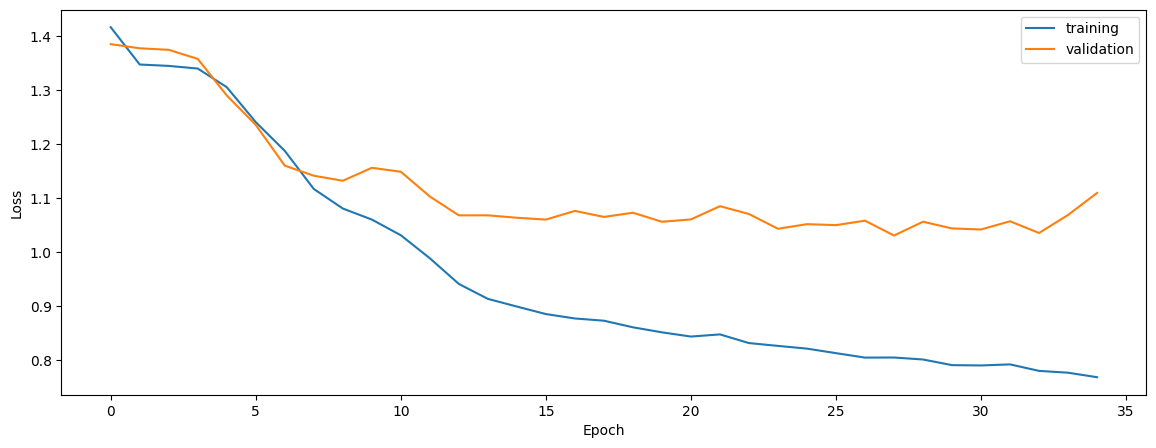

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6861344908651802
0.6304749875952907
0.6981591770438549


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6861344908651802
0.6304749875952907
0.6981591770438549


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6801370088594672
0.6249298147108366
0.7020963589554984


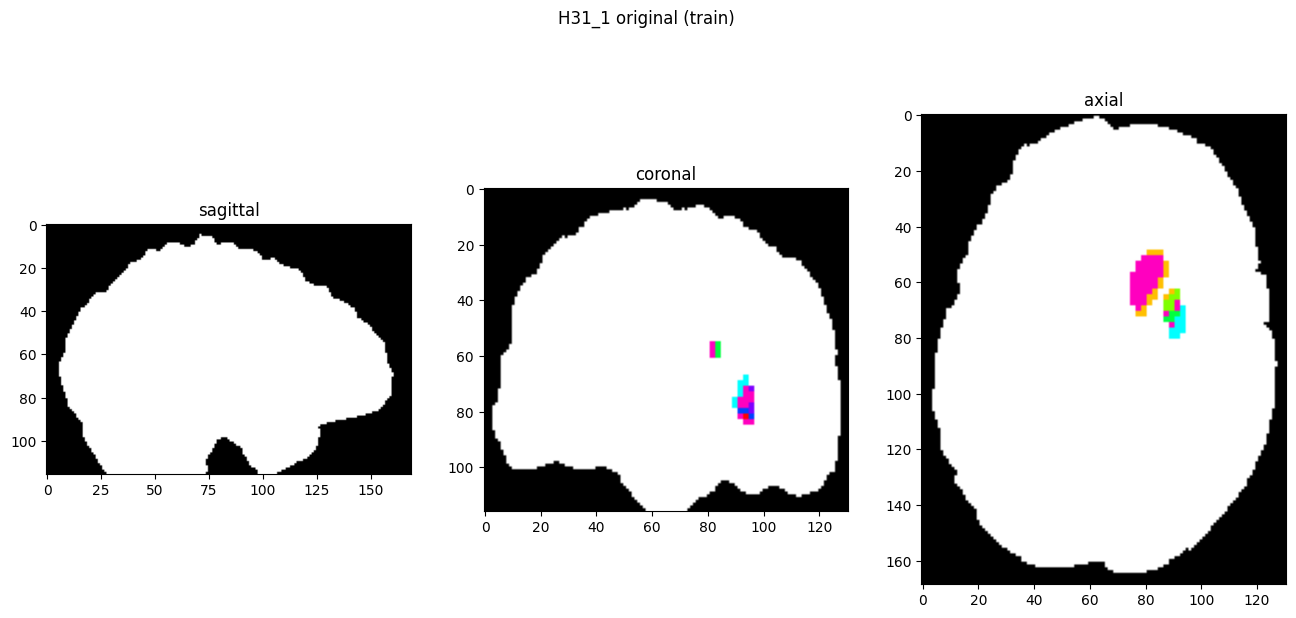

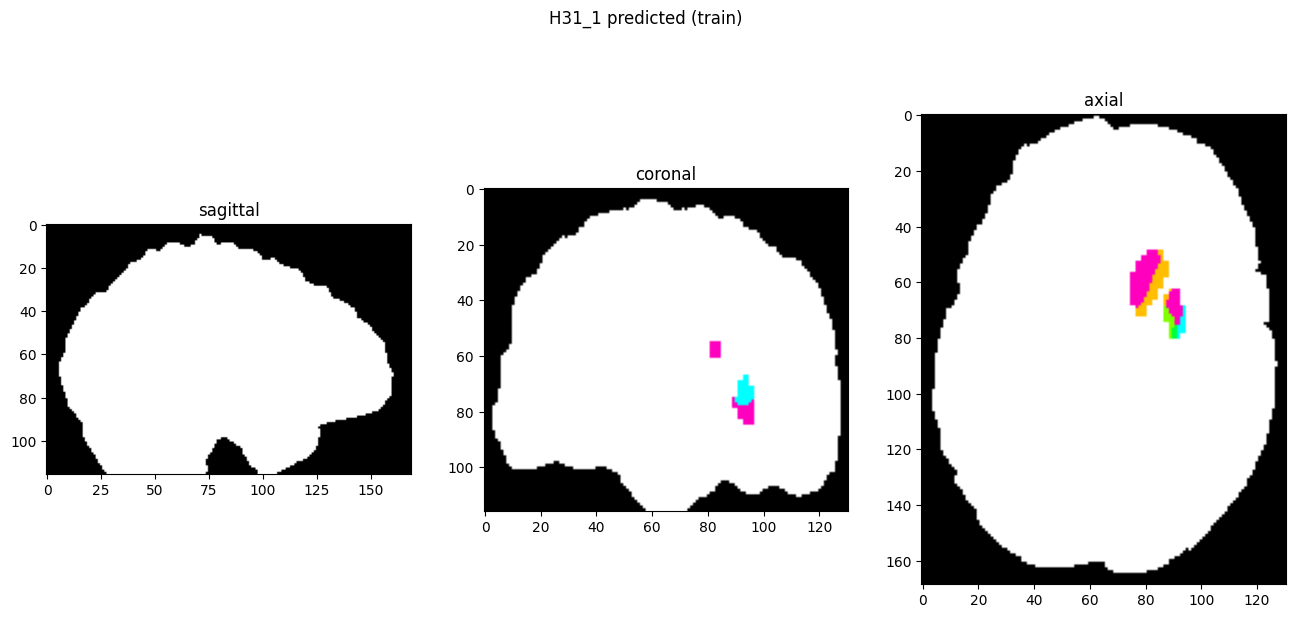

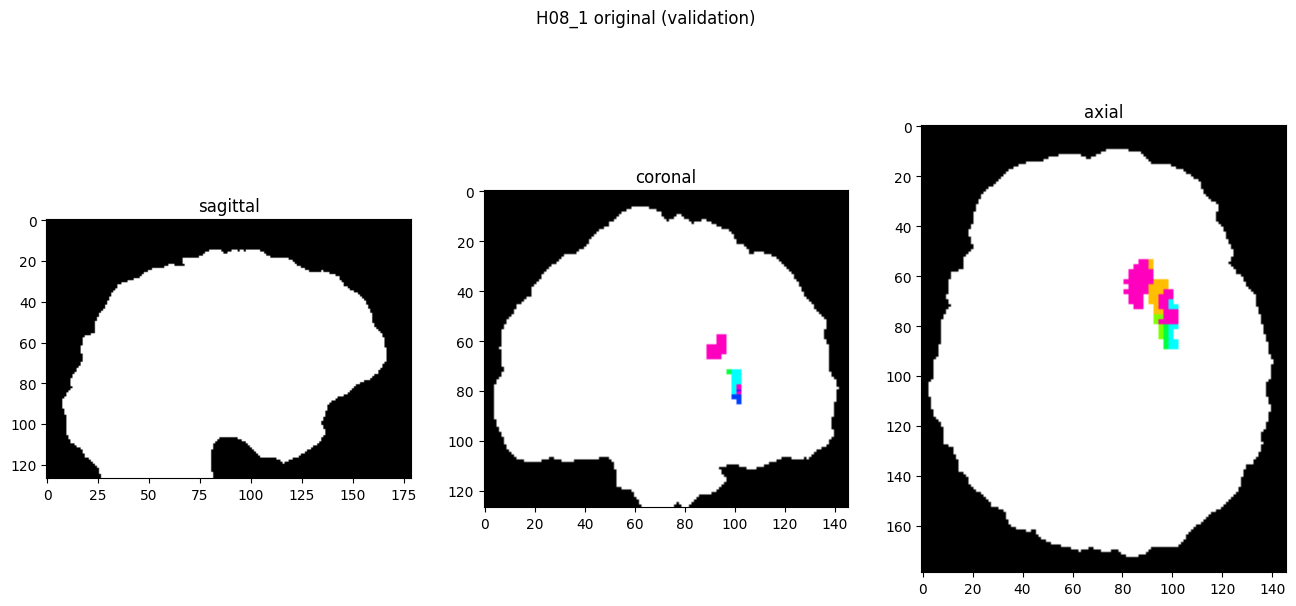

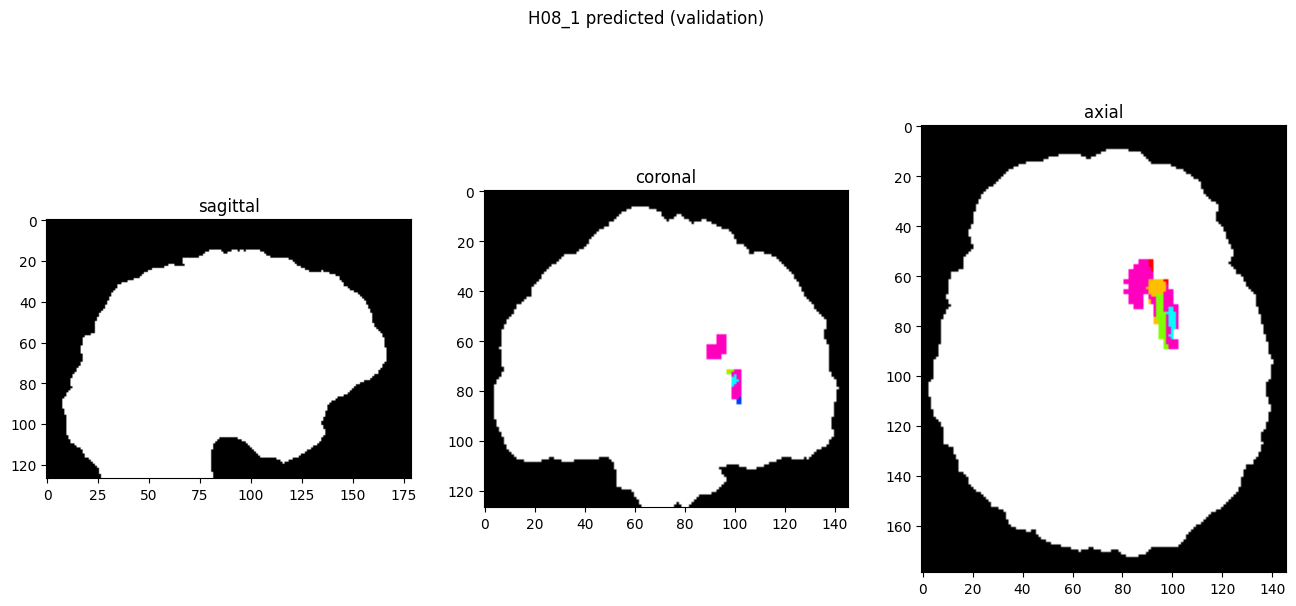

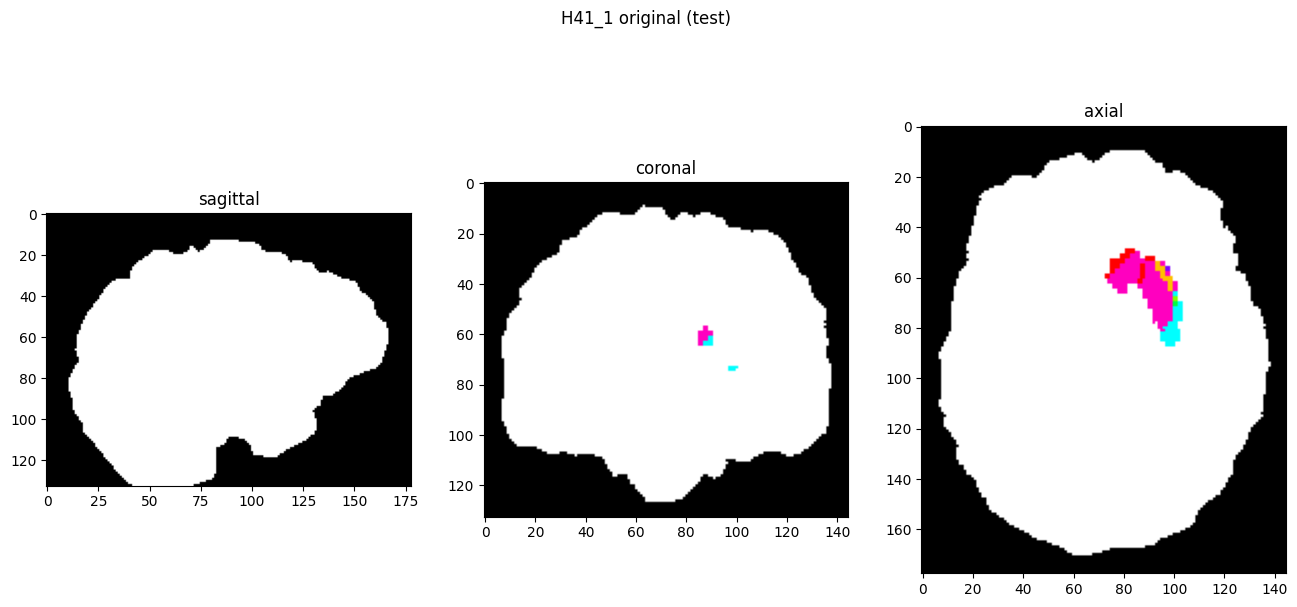

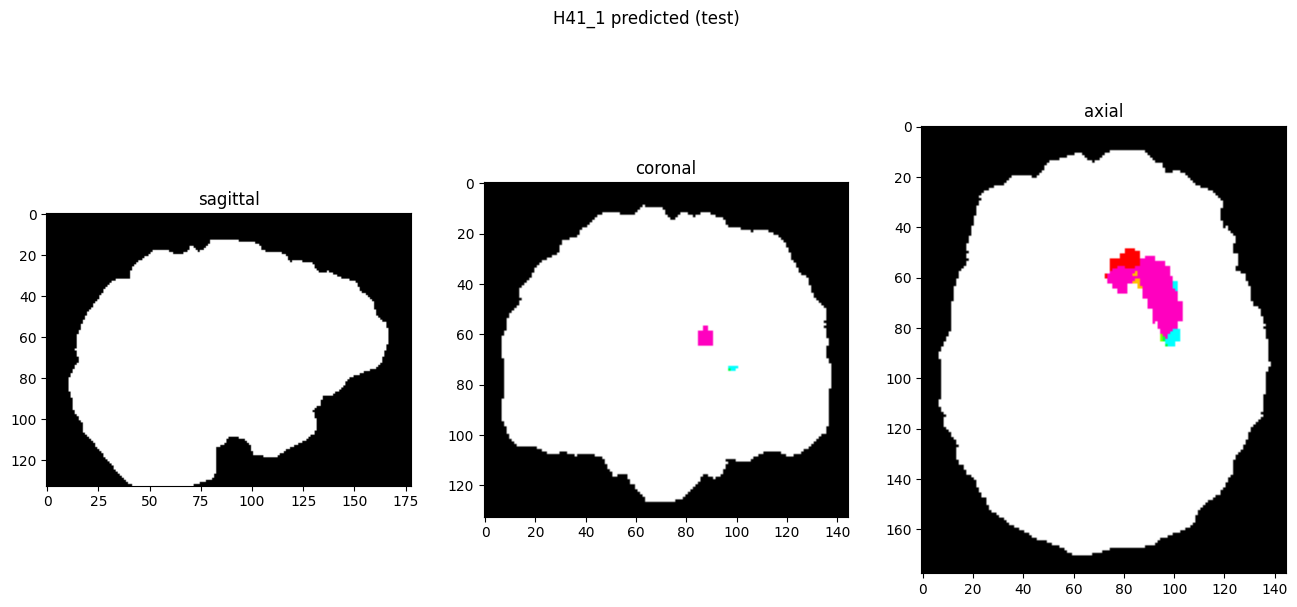

In [10]:
showResults(model, gen, threshold=0)